# Capstone - Feature Engineering and Modelling Part II
Date: 2021.11.27<br>
William Matthews

### Report Objectives and Flow

This report will implement the learnings from the EDA and Modelling Part I report with the goal of increasing the overall accuracy, the precision, and the recall of our models in predicting if the Peak chair at Whistler will open on a given day.  We will attempt to engineer at least one additional feature as well as remove features we have identified as un-consequential.

The models in this report will utilize a composite dataset from the Port Hardy and Quillayute weather balloon stations.  Because of this, we will run a suite of models against our data to determine the effect of this change before moving onto any other feature engineering or manipulation.  After each change in features, we will re-run our models to get an understanding of the value of the work we have done on the features.  Finally, we will pick our best model and run hyperparameterization against it.

### Data Sets

We will be bringing in 4 data sets for this model building.  We will be using the _PowDayHistory_ as our target variables, and the _RoundHouseClean_ data and _CombinedBallonDataCleaned_ for our features.  We will also be bringing in _BaseLineModelScores_ which contains the confusion matrix values for all the models previously run on our data.  We will use this to evaluate the effectiveness of removing some noisy data as well as the effectiveness of features we engineer.

### Library and Data Imports

In [1]:
# data handling
import numpy as np
import pandas as pd

# managing timestamps
from datetime import datetime
from datetime import timedelta

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns

# text manipulation
from textwrap import wrap

# sklearn - data prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# sklearn - evaluation tools
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

In [2]:
# set font size for all plots
mpl.rcParams.update({'font.size': 16})
# allow

In [3]:
# import data
pow_day_df = pd.read_csv('./Data/PowDayHistoryClean.csv')
balloon_df = pd.read_csv('./Data/CombinedBalloonDataClean.csv')
rh_df = pd.read_csv('./Data/RoundHouseClean.csv')
scores_df = pd.read_csv('./Data/BaseLineModelScores.csv')

In [4]:
# confirm things imported as expected
display(pow_day_df,
        balloon_df,
        rh_df,
        scores_df)

,time,lift,day_status
0,2014-12-31 00:00:00,Whistler Village Gondola,0
1,2014-12-31 00:00:00,Jersey Cream,0
2,2014-12-31 00:00:00,Crystal,0
3,2014-12-31 00:00:00,7th Heaven,0
4,2014-12-31 00:00:00,Glacier,0
...,...,...,...
26259,2021-03-29 09:28:27,Peak,1
26260,2021-03-29 10:09:30,Harmony,1
26261,2021-03-29 10:14:06,Excalibur Gondola,1
26262,2021-03-29 10:30:08,Symphony,1


,DATE,TEMP,DWPT,RELH,MIXR,DRCT,SKNT
0,2014-12-31 16:00:00,-1.200000,-10.200000,50.000000,2.525000,15.000000,19.000000
1,2015-01-01 04:00:00,-0.822222,-12.644444,40.555556,2.111111,340.555556,12.888889
2,2015-01-01 16:00:00,-2.100000,-10.175000,55.250000,2.615000,335.000000,16.250000
3,2015-01-02 04:00:00,-2.320000,-7.220000,69.400000,3.186000,280.800000,35.600000
4,2015-01-02 16:00:00,-4.225000,-41.975000,3.750000,0.147500,289.500000,39.250000
...,...,...,...,...,...,...,...
2430,2021-04-14 16:00:00,-0.720000,-22.280000,17.800000,0.922000,64.800000,17.600000
2431,2021-04-15 04:00:00,-2.500000,-13.833333,41.666667,1.883333,61.666667,14.000000
2432,2021-04-15 16:00:00,-1.825000,-19.175000,25.500000,1.227500,80.750000,11.000000
2433,2021-04-16 04:00:00,-0.640000,-21.900000,19.200000,0.984000,90.800000,10.000000


,Date/Time,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Snow on Grnd (cm)
0,2015-01-01,4.5,0.5,2.5,0.0,0,0.0,1,117.0
1,2015-01-02,-3.0,-6.0,-4.5,0.0,0,0.0,1,116.0
2,2015-01-03,-6.0,-9.0,-7.5,0.0,0,5.0,0,115.0
3,2015-01-04,0.0,-8.0,-4.0,0.0,0,33.0,0,132.0
4,2015-01-05,3.0,-5.0,-1.0,23.0,0,6.0,0,149.0
...,...,...,...,...,...,...,...,...,...
932,2021-03-25,2.0,-6.0,-2.0,0.0,0,0.0,0,280.0
933,2021-03-26,1.0,-5.5,-2.3,0.0,0,0.0,0,275.0
934,2021-03-27,-0.5,-4.5,-2.5,0.0,0,14.0,0,274.0
935,2021-03-28,-3.5,-5.5,-4.5,0.0,0,15.0,0,287.0


,Unnamed: 0,True Negative,False Positive,False Negative,True Positive
0,Base_Line_Logistic,22,24,25,130
1,Base_Line_Tree,29,17,21,134
2,Base_Line_KNN,17,29,10,145
3,Base_Line_Forest,25,21,8,147
4,Base_Line_SVM,21,25,10,145


In [5]:
# clean up header of scores_df
scores_df.rename(columns = {'Unnamed: 0': 'Model Name'}, inplace = True)

In [6]:
# add a Model Iteration Field as the second column and extract Base from first column
scores_df.insert(1, 'Model Iteration', scores_df['Model Name'].apply(lambda x: x[0:9]))

In [7]:
# remove the Base_ prefix from the Model Name column
scores_df['Model Name'] = scores_df['Model Name'].apply(lambda x: x[10:])

In [8]:
# update names to proper names so we can use them in graph titles
for i in range(scores_df.shape[0]):
    if scores_df.iloc[i, 0] == 'Logistic':
        scores_df.iloc[i, 0] = 'Logistic Regression'
    if scores_df.iloc[i, 0] == 'Tree':
        scores_df.iloc[i, 0] = 'Decision Tree'
    if scores_df.iloc[i, 0] == 'Forest':
        scores_df.iloc[i, 0] = 'Random Forest'
    

In [9]:
# check manipulations worked
scores_df

,Model Name,Model Iteration,True Negative,False Positive,False Negative,True Positive
0,Logistic Regression,Base_Line,22,24,25,130
1,Decision Tree,Base_Line,29,17,21,134
2,KNN,Base_Line,17,29,10,145
3,Random Forest,Base_Line,25,21,8,147
4,SVM,Base_Line,21,25,10,145


Our data was successfully imported.  On import, we realized our scores data frame could be better structured, so we split one of the columns into two to help with data tracking down the line.  Let's check the columns quickly before moving on.

In [10]:
display(pow_day_df.info(),
        balloon_df.info(),
        rh_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26264 entries, 0 to 26263
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   time        26264 non-null  object
 1   lift        26264 non-null  object
 2   day_status  26264 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 615.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2435 entries, 0 to 2434
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    2435 non-null   object 
 1   TEMP    2435 non-null   float64
 2   DWPT    2435 non-null   float64
 3   RELH    2435 non-null   float64
 4   MIXR    2435 non-null   float64
 5   DRCT    2435 non-null   float64
 6   SKNT    2435 non-null   float64
dtypes: float64(6), object(1)
memory usage: 133.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dty

None

None

None

It looks like everything is good with the exceptin of the date and time columns.  Let's change these to date time objects.

In [11]:
# change all date/time columns to datetime objects
pow_day_df['time'] = pd.to_datetime(pow_day_df['time'])
balloon_df['DATE'] = pd.to_datetime(balloon_df['DATE'])
rh_df['Date/Time'] = pd.to_datetime(rh_df['Date/Time'])

### Data Wrangling

Here we are going to focus on constructing a data frame where each row consists of a target and each of its features.  Because we are going to be using the lags, or the data from the preceeding days as well, we are going to build out our data frame with column names very similar to how we did it in our _EDAAndModellingPartI_ report.

The biggest difference between the previous report and this one is that we are going to cap the lag values at three days max instead of 5.  After discussion with weather experts, they felt it was unlikely that anything past one to two days lag would have much effect on the opening of the Peak chair.

Let's move on to complete all of the transformations we did in our previous report.

In [12]:
# get an empty list of column names to build column names on
col_names = []

# list of lag values to attach to each column from ballon data
ballon_suffixes = []
for lag in range(0, 96, 12):
    ballon_suffixes.append(f"_L{lag}h")
    
# build column names from balloon dataset
# loop through all columns
for col in balloon_df.columns:
    
    # don't take the date column
    if col != 'DATE':
        
        # add each suffix to the column name
        for lag in ballon_suffixes:
            col_names.append(f"{col}{lag}")

# build lag suffixes for powday and roundhouse data
pow_rh_suffixes = []
for lag in range(0,73, 24):
    pow_rh_suffixes.append(f"_L{lag}h")

# build column names for roundhouse data
for col in rh_df.columns:
    
    # don't take the date/time column
    if col != 'Date/Time':
        
        # add each suffix to the column name
        for lag in pow_rh_suffixes:
            col_names.append(f"{col}{lag}")

# build column names for powday data
col = 'day_status'

# add each suffix to the column name
for lag in pow_rh_suffixes:
    col_names.append(f"{col}{lag}")

# add a day of the week column
col_names.append('day_of_week')

# check to see it all has worked
col_names

['TEMP_L0h',
 'TEMP_L12h',
 'TEMP_L24h',
 'TEMP_L36h',
 'TEMP_L48h',
 'TEMP_L60h',
 'TEMP_L72h',
 'TEMP_L84h',
 'DWPT_L0h',
 'DWPT_L12h',
 'DWPT_L24h',
 'DWPT_L36h',
 'DWPT_L48h',
 'DWPT_L60h',
 'DWPT_L72h',
 'DWPT_L84h',
 'RELH_L0h',
 'RELH_L12h',
 'RELH_L24h',
 'RELH_L36h',
 'RELH_L48h',
 'RELH_L60h',
 'RELH_L72h',
 'RELH_L84h',
 'MIXR_L0h',
 'MIXR_L12h',
 'MIXR_L24h',
 'MIXR_L36h',
 'MIXR_L48h',
 'MIXR_L60h',
 'MIXR_L72h',
 'MIXR_L84h',
 'DRCT_L0h',
 'DRCT_L12h',
 'DRCT_L24h',
 'DRCT_L36h',
 'DRCT_L48h',
 'DRCT_L60h',
 'DRCT_L72h',
 'DRCT_L84h',
 'SKNT_L0h',
 'SKNT_L12h',
 'SKNT_L24h',
 'SKNT_L36h',
 'SKNT_L48h',
 'SKNT_L60h',
 'SKNT_L72h',
 'SKNT_L84h',
 'Max Temp (°C)_L0h',
 'Max Temp (°C)_L24h',
 'Max Temp (°C)_L48h',
 'Max Temp (°C)_L72h',
 'Min Temp (°C)_L0h',
 'Min Temp (°C)_L24h',
 'Min Temp (°C)_L48h',
 'Min Temp (°C)_L72h',
 'Mean Temp (°C)_L0h',
 'Mean Temp (°C)_L24h',
 'Mean Temp (°C)_L48h',
 'Mean Temp (°C)_L72h',
 'Total Rain (mm)_L0h',
 'Total Rain (mm)_L24h',
 'Total 

In [13]:
# extract all unique dates from the date-time column
ref_dates = pow_day_df['time'].apply(lambda d: d.date()).unique()

# build data frame and fill with NaN values
model_template_df = pd.DataFrame(np.NaN, index = ref_dates, columns = col_names)

# check to see it worked
model_template_df

,TEMP_L0h,TEMP_L12h,TEMP_L24h,TEMP_L36h,TEMP_L48h,TEMP_L60h,TEMP_L72h,TEMP_L84h,DWPT_L0h,DWPT_L12h,...,Total Snow Flag_L72h,Snow on Grnd (cm)_L0h,Snow on Grnd (cm)_L24h,Snow on Grnd (cm)_L48h,Snow on Grnd (cm)_L72h,day_status_L0h,day_status_L24h,day_status_L48h,day_status_L72h,day_of_week
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# fill all Balloon data points

# loop through all target dates
for target_date in model_template_df.index:

    # force target date time to match first expected record (4PM for the current day)
    target_date_with_time = datetime(target_date.year, target_date.month, target_date.day, 16)
    
    # loop to cycle through all of our lags
    for lag in range(0, 96, 12):

        # get record for correct lag period
        lag_record = balloon_df[balloon_df['DATE'].apply(lambda d: d + timedelta(hours = lag)) == target_date_with_time]
        
        # get the number of rows in the lag_record
        num_rows = lag_record.shape[0]
        
        # if we have more than one row in our lag record, assert an error
        if num_rows > 1:
            assert True, f'We have a duplicate lag record at indicies {lag_record.index}'
        
        # if we have exactly one row, proceed
        elif num_rows == 1:
            
            # loop to cycle through all columns in lag_recrods except Date/Time
            for col in lag_record.columns:
                
                # proceed if col is NOT date/time
                if col != 'DATE':
                    
                    # compose target column name from column extracted, and lag value
                    target_column_suffix = f"_L{abs(lag)}h"
                    target_column = f"{col}{target_column_suffix}"

                    # write the lag_record to the correct row in model_template
                    model_template_df.loc[target_date, target_column] = lag_record[col].values[0]

        # if the value is 0, do nothing and leave NaN values in our data frame
        else:
            pass     

In [15]:
# check to see things went as expected.
model_template_df

,TEMP_L0h,TEMP_L12h,TEMP_L24h,TEMP_L36h,TEMP_L48h,TEMP_L60h,TEMP_L72h,TEMP_L84h,DWPT_L0h,DWPT_L12h,...,Total Snow Flag_L72h,Snow on Grnd (cm)_L0h,Snow on Grnd (cm)_L24h,Snow on Grnd (cm)_L48h,Snow on Grnd (cm)_L72h,day_status_L0h,day_status_L24h,day_status_L48h,day_status_L72h,day_of_week
2014-12-31,-1.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.200000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,-2.100000,-0.822222,-1.200000,NaN,NaN,NaN,NaN,NaN,-10.175000,-12.644444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-4.225000,-2.320000,-2.100000,-0.822222,-1.200000,NaN,NaN,NaN,-41.975000,-7.220000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,-6.175000,-5.080000,-4.225000,-2.320000,-2.100000,-0.822222,-1.200000,NaN,-23.112500,-39.440000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,0.050000,-4.250000,-6.175000,-5.080000,-4.225000,-2.320000,-2.100000,-0.822222,0.000000,-5.766667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,-4.260000,-10.640000,-9.700000,-7.100000,-5.200000,-8.633333,-14.400000,-12.866667,-43.460000,-15.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-26,-2.666667,-4.800000,-4.260000,-10.640000,-9.700000,-7.100000,-5.200000,-8.633333,-23.833333,-9.125000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-27,-4.000000,-2.342857,-2.666667,-4.800000,-4.260000,-10.640000,-9.700000,-7.100000,-13.250000,-16.342857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-28,-18.300000,-13.320000,-4.000000,-2.342857,-2.666667,-4.800000,-4.260000,-10.640000,-21.200000,-21.480000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# fill all Roundhouse trailing data points

# loop through all target dates
for target_date in model_template_df.index:
    
    # loop to cycle through all of our lags - must be in hours to match with column names
    for lag in range(0, 73, 24):

        # get record for correct lag period
        lag_record = rh_df[rh_df['Date/Time'].apply(lambda d: d.date() + timedelta(days = lag/24)) == target_date]
        
        # get the number of rows in the lag_record
        num_rows = lag_record.shape[0]
        
        # if we have more than one row in our lag record, assert an error
        if num_rows > 1:
            assert True, f'We have a duplicate lag record at indicies {lag_record.index}'
        
        # if we have exactly one row, proceed
        elif num_rows == 1:
            
            # loop to cycle through all columns in lag_recrods except Date/Time
            for col in lag_record.columns:
                
                # proceed if col is NOT date/time
                if col != 'Date/Time':
                    
                    # compose target column name from column extracted, and lag value
                    target_column_suffix = f"_L{abs(lag)}h"
                    target_column = f"{col}{target_column_suffix}"

                    # write the lag_record to the correct row in model_template
                    model_template_df.loc[target_date, target_column] = lag_record[col].values[0]

        # if the value is 0, do nothing and leave NaN values in our data frame
        else:
            pass     

In [17]:
day_of_week = []

for i in range(0, model_template_df.shape[0]):
    day_of_week.append(model_template_df.index[i].strftime('%a'))

model_template_df['day_of_week'] = day_of_week

model_template_df

,TEMP_L0h,TEMP_L12h,TEMP_L24h,TEMP_L36h,TEMP_L48h,TEMP_L60h,TEMP_L72h,TEMP_L84h,DWPT_L0h,DWPT_L12h,...,Total Snow Flag_L72h,Snow on Grnd (cm)_L0h,Snow on Grnd (cm)_L24h,Snow on Grnd (cm)_L48h,Snow on Grnd (cm)_L72h,day_status_L0h,day_status_L24h,day_status_L48h,day_status_L72h,day_of_week
2014-12-31,-1.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.200000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wed
2015-01-01,-2.100000,-0.822222,-1.200000,NaN,NaN,NaN,NaN,NaN,-10.175000,-12.644444,...,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thu
2015-01-02,-4.225000,-2.320000,-2.100000,-0.822222,-1.200000,NaN,NaN,NaN,-41.975000,-7.220000,...,NaN,116.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,Fri
2015-01-03,-6.175000,-5.080000,-4.225000,-2.320000,-2.100000,-0.822222,-1.200000,NaN,-23.112500,-39.440000,...,NaN,115.0,116.0,117.0,NaN,NaN,NaN,NaN,NaN,Sat
2015-01-04,0.050000,-4.250000,-6.175000,-5.080000,-4.225000,-2.320000,-2.100000,-0.822222,0.000000,-5.766667,...,1.0,132.0,115.0,116.0,117.0,NaN,NaN,NaN,NaN,Sun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,-4.260000,-10.640000,-9.700000,-7.100000,-5.200000,-8.633333,-14.400000,-12.866667,-43.460000,-15.700000,...,0.0,280.0,285.0,284.0,289.0,NaN,NaN,NaN,NaN,Thu
2021-03-26,-2.666667,-4.800000,-4.260000,-10.640000,-9.700000,-7.100000,-5.200000,-8.633333,-23.833333,-9.125000,...,0.0,275.0,280.0,285.0,284.0,NaN,NaN,NaN,NaN,Fri
2021-03-27,-4.000000,-2.342857,-2.666667,-4.800000,-4.260000,-10.640000,-9.700000,-7.100000,-13.250000,-16.342857,...,1.0,274.0,275.0,280.0,285.0,NaN,NaN,NaN,NaN,Sat
2021-03-28,-18.300000,-13.320000,-4.000000,-2.342857,-2.666667,-4.800000,-4.260000,-10.640000,-21.200000,-21.480000,...,0.0,287.0,274.0,275.0,280.0,NaN,NaN,NaN,NaN,Sun


In [18]:
# one hot encode day of week and drop the first day
model_template_df = pd.get_dummies(model_template_df,
                                   columns = ['day_of_week'],
                                   drop_first = True)

In [19]:
# list to store column names
drct_cols = []

# find all columns with DRCT in the column header
for col in model_template_df.columns:
    if col.find('DRCT') != -1:
        drct_cols.append(col)

# for each column in our subset
for col in drct_cols:
    
    # compose sin column name
    sin_col = f"sin_{col}"
    
    # calculate sin transform and store in a new column
    model_template_df[sin_col] = np.sin(model_template_df[col]/360*2*np.pi)
    
    # compose cos column name
    cos_col = f"cos_{col}"
    
    # calculate cos transform and store in a new column
    model_template_df[cos_col] = np.cos(model_template_df[col]/360*2*np.pi)
    
    # delete the original column
    model_template_df.drop(columns = col, inplace = True)

In [20]:
# check we have the columns we want.
model_template_df.columns

Index(['TEMP_L0h', 'TEMP_L12h', 'TEMP_L24h', 'TEMP_L36h', 'TEMP_L48h',
       'TEMP_L60h', 'TEMP_L72h', 'TEMP_L84h', 'DWPT_L0h', 'DWPT_L12h',
       'DWPT_L24h', 'DWPT_L36h', 'DWPT_L48h', 'DWPT_L60h', 'DWPT_L72h',
       'DWPT_L84h', 'RELH_L0h', 'RELH_L12h', 'RELH_L24h', 'RELH_L36h',
       'RELH_L48h', 'RELH_L60h', 'RELH_L72h', 'RELH_L84h', 'MIXR_L0h',
       'MIXR_L12h', 'MIXR_L24h', 'MIXR_L36h', 'MIXR_L48h', 'MIXR_L60h',
       'MIXR_L72h', 'MIXR_L84h', 'SKNT_L0h', 'SKNT_L12h', 'SKNT_L24h',
       'SKNT_L36h', 'SKNT_L48h', 'SKNT_L60h', 'SKNT_L72h', 'SKNT_L84h',
       'Max Temp (°C)_L0h', 'Max Temp (°C)_L24h', 'Max Temp (°C)_L48h',
       'Max Temp (°C)_L72h', 'Min Temp (°C)_L0h', 'Min Temp (°C)_L24h',
       'Min Temp (°C)_L48h', 'Min Temp (°C)_L72h', 'Mean Temp (°C)_L0h',
       'Mean Temp (°C)_L24h', 'Mean Temp (°C)_L48h', 'Mean Temp (°C)_L72h',
       'Total Rain (mm)_L0h', 'Total Rain (mm)_L24h', 'Total Rain (mm)_L48h',
       'Total Rain (mm)_L72h', 'Total Rain Flag_L0h', 'Tot

The above transformations include building our data frame to accept 3 days of lag from each of our variables and writing the correct data from each data source into our constructed data frame.  It also includes transforming our wind direction feature from one column in degrees to two columns, the sin and cosine of the wind angle.  We now have a template into which we can insert any of our chair lifts.  For the purpose of this report we will be focussing on the Peak chair only.  Let's build out that dataframe now.

In [21]:
# create a copy
peak_df = model_template_df.copy(deep = True)

In [22]:
# fill all PowDay trailing data points

# loop through all target dates
for target_date in peak_df.index:
    
    # loop to cycle through all of our lags - must be in hours to match with column names
    for lag in range(0, 73, 24):

        # get record for correct lag period
        lag_record = pow_day_df[(pow_day_df['time'].apply(lambda d: d.date() + timedelta(days = lag/24)) == target_date) &
                                           (pow_day_df['lift'] == 'Peak')]
        
        # get the number of rows in the lag_record
        num_rows = lag_record.shape[0]
        
        # if we have more than one row in our lag record, assert an error
        if num_rows > 1:
            assert True, f'We have a duplicate lag record at indicies {lag_record.index}'
        
        # if we have exactly one row, proceed
        elif num_rows == 1:
            
            # extract the day_status column only
            col = 'day_status'
                
            # compose target column name from column extracted, and lag value
            target_column_suffix = f"_L{abs(lag)}h"
            target_column = f"{col}{target_column_suffix}"

            # write the lag_record to the correct row in model_template
            peak_df.loc[target_date, target_column] = lag_record[col].values[0]

        # if the value is 0, do nothing and leave NaN values in our data frame
        else:
            pass     

Now that we have placed all the data we have into our data frame, let's take a look at how many missing values we still have.

In [23]:
# total number of rows
rows = peak_df.shape[0]

# number of missing ros
missing_rows = rows - peak_df.dropna().shape[0]

print(f"Total rows: {rows}")
print(f"Missing rows: {missing_rows}")
print(f"Percent missing rows: {100*missing_rows/rows: .1f}%")

Total rows: 938
Missing rows: 65
Percent missing rows:  6.9%


It looks like our changes have reduced the number of missing rows from roughly 30% down to 6.5%.  Hopefully this will be enough to boost our models efficacy.  If not, we may have to look at another round of imputing.  Let's drop our missing rows and move on.

In [24]:
# drop all rows with NaN values
peak_df = peak_df.dropna()

### Preperation for Model Iterations

In order to track how our various scoring metrics are changing with each feature we drop our engineer, we are going to write a few helper functions that make it easy to fit, predicit, score, and visualize after each successive iteration.

In [25]:
def split_fit_score(current_df, iteration_num, upsample = False):
    """
    Takes a data frame of the current data set and string of current iteration, splits it into train and test, fits each of our models,
    scores each of our models, and returns a list of lists which contains model name, iteration, and confusion matrix values
    """
    # split data in to dependent and independent variables - drop the datetime column
    X = current_df.drop(columns = ['day_status_L0h'])
    y = current_df['day_status_L0h']

    # split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)
    
    # if we are going to upsample
    if upsample:
        
        # generate additional samples by making perfectly balanced classes
        X_upsampled, y_upsampled = resample(X_train[y_train == 0],
                                            y_train[y_train == 0],
                                            replace = True,
                                            n_samples = X_train[y_train == 1].shape[0],
                                            random_state = 42)
        
        # combine upsamples with original data so classes are balanced
        X_train = np.vstack((X_train[y_train == 1], X_upsampled))
        y_train = np.hstack((y_train[y_train == 1], y_upsampled))
    
    
    # fit scaler on train data and transform
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # scale test data
    X_test_scaled = scaler.transform(X_test)
    
    # fit logistic model
    logmod = LogisticRegression()
    logmod.fit(X_train_scaled, y_train)

    # fit decision tree - don't worry about using scaled data
    tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
    tree.fit(X_train, y_train)

    # fit knn model
    knn = KNeighborsClassifier()
    knn.fit(X_train_scaled, y_train)

    # fit random forest model
    random_forest = RandomForestClassifier(random_state = 42)
    random_forest.fit(X_train, y_train)

    # fit svm model
    svm = SVC(random_state = 42)
    svm.fit(X_train_scaled, y_train)
    
    # run each models prediction again and save result of confusion matrix
    scores = []

    # logistic
    y_pred = logmod.predict(X_test_scaled)
    scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

    # decision tree
    y_pred = tree.predict(X_test)
    scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

    # knn
    y_pred = knn.predict(X_test_scaled)
    scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

    # random forest
    y_pred = random_forest.predict(X_test)
    scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

    # svm
    y_pred = svm.predict(X_test_scaled)
    scores.append(np.ravel(confusion_matrix(y_test, y_pred)))
    
    # build list of model names
    model_names = list(scores_df['Model Name'].unique())

    # build list of iteration number
    iteration_id = []
    for _ in model_names:
        iteration_id.append(iteration_num)

    # build list of all data to add to data frame
    latest_scores = []
    for model_name, iteration, score in zip(model_names, iteration_id, scores):
    
        # build empty list and add each element to it
        data = []
        data.append(model_name)
        data.append(iteration)
        # unpack the array into individual values to put into the list
        for s in score:
            data.append(s)

        # add the list to latest scores list
        latest_scores.append(data)
        
    return latest_scores

In [26]:
def plot_model_iterations(scores_df):
    """
    Takes a data frame of scores and produces a series of line plots for visualizing
    the changes over each model iteration.

    """
    
    # get a deep copy of the data frame so we don't mess with the scores_df
    df = scores_df.copy(deep = True)
    
    # calculate overall accuracy
    df['Accuracy'] = (df['True Positive'] + df['True Negative'])/ \
                     (df['True Positive'] + df['True Negative'] + 
                      df['False Positive'] + df['False Negative'])
    
    # calculate closed precision
    df['Precision-Closed'] = df['True Negative']/ \
                             (df['True Negative'] + df['False Negative'])
    
    # calculate closed recall
    df['Recall-Closed'] =  df['True Negative']/ \
                           (df['True Negative'] + df['False Positive'])
    
    # calculate open precision
    df['Precision-Open'] = df['True Positive']/ \
                           (df['True Positive'] + df['False Positive'])
                          
    # calculate open recall
    df['Recall-Open'] = df['True Positive']/ \
                           (df['True Positive'] + df['False Negative'])
    
    # change all score columns to percentages, rounded to 0 decimals
    df[['Accuracy', 'Precision-Closed', 'Recall-Closed',
        'Precision-Open', 'Recall-Open']] = df[['Accuracy', 'Precision-Closed', 'Recall-Closed',
                                                'Precision-Open', 'Recall-Open']].apply(lambda x: round(x*100, 0))

    # get list of model names
    models = list(df['Model Name'].unique())
    
    # work out number of rows needed based on number of columns
    figure_cols = 2
    figure_rows = int(np.ceil((len(models))/figure_cols)) 
    
    # plot one subplot per model name, plus an overall plot for accuracy, precision, recall
    fig, axes = plt.subplots(figure_rows,
                             figure_cols,
                             figsize = (figure_cols*6, figure_rows*4.5 ))
    
    # flaten out axes array
    flat_ax = np.ravel(axes)
    
    # line plots for each model plot, remove last axis
    for ax, model in zip(flat_ax[:-1], models):
        
        # filter the df by the model
        df_to_plot = df[df['Model Name'] == model]
        
        # plot the data
        ax.plot(df_to_plot['Model Iteration'],
                df_to_plot[['Accuracy', 'Precision-Closed', 'Recall-Closed', 'Precision-Open', 'Recall-Open']],
                label = ['Accuracy', 'Precision-Closed', 'Recall-Closed', 'Precision-Open', 'Recall-Open'])
        
        # set yaxis limits to be matching for all
        ax.set_ylim(30, 100)
        
        # set the xticks to be minimum of 5 (will make the visuals easier to compare over time)
        ax.set_xticks(np.arange(0, max(len(models), 8), 1))    
        
        # set title of subplot
        ax.set_title(f"{model}")
        
        # add x labels
        ax.set_xlabel('Model Iteration')
        
        # add y-labels
        ax.set_ylabel('Percentage of Metric')
        
        # add grid lines
        ax.grid()
        
        # store last axis info for creating unified legend
        handles, labels = ax.get_legend_handles_labels()
        
    # add figure title
    fig.suptitle('Model Performance Metrics Over Feature\nEngineering and Removal')
    
    # turn off the last axis to leave room for the legends
    flat_ax[-1].axis('off')

    # update legend labels with best score and which model
    for i, metric in enumerate(labels):
        
        # get the index of the best row
        index_best_row = df[metric].idxmax()
        
        # get best score and best model name
        best_score = df.loc[index_best_row, metric]
        best_model = df.loc[index_best_row, 'Model Name']
        best_iteration = df.loc[index_best_row, 'Model Iteration']
       
        # build string
        new_label = f"{metric} (Best is {best_score: .0f}% from {best_model}-{best_iteration})"
        
        # put string back into labels
        labels[i] = new_label
    
    # force labels for wrap in the legend
    labels = [ '\n'.join(wrap(l, 30)) for l in labels]
    
    # add legend for  model metrics to figure
    fig.legend(handles, labels,
               title = 'Model Metrics',
               bbox_to_anchor = (0.95, 0.3))
    
    # align layout
    fig.tight_layout()
    
    plt.show()

_Credit to [this StackOverflow post](https://stackoverflow.com/questions/47057789/matplotlib-wrap-text-in-legend) for the solution to wrap text in a legend_

### Model Iteration I - Decreasing Data Loss

The purpose of this first iteration is to see the effect of the changes we have made since the base line model.  These changes are:
- Combining the weather ballon data into one dataset to eliminate as many null values as possible
- Deleting the pressure and height columns from the ballon data sets
- Reducing the number of lag days for each variable from 5 to 3.<br>

Let's run each of the models we previously ran again and see how they compared against our baseline.

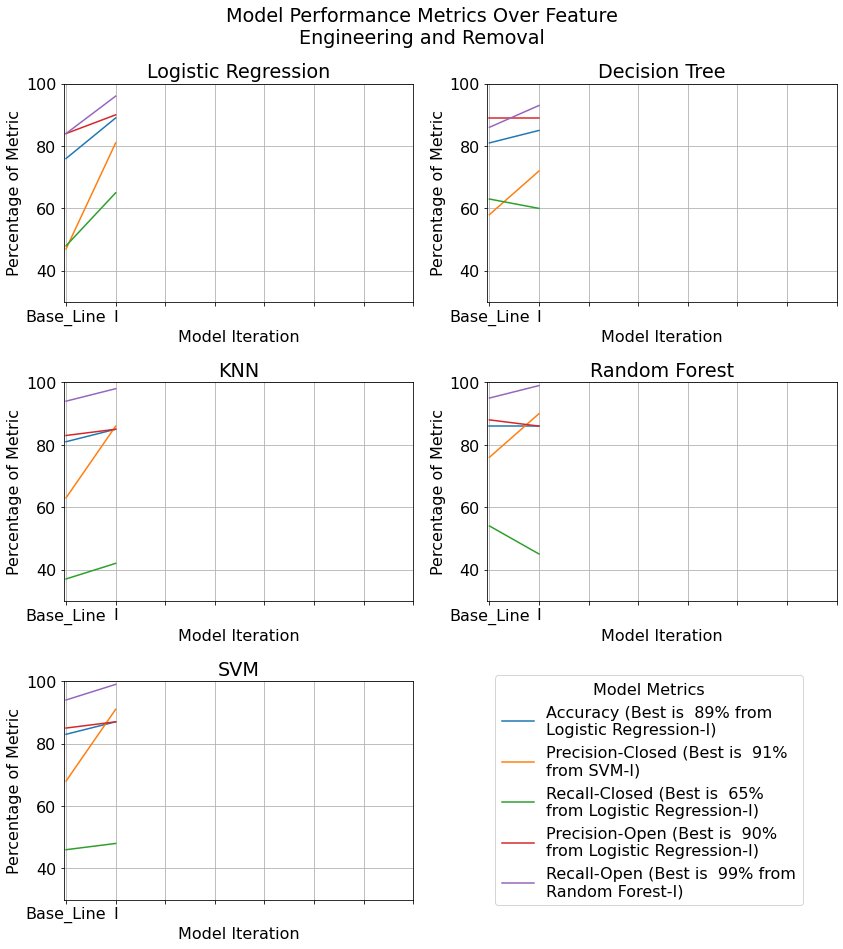

In [27]:
# run latest data against suite of models
latest_scores = split_fit_score(peak_df, 'I')

# add latest scores to our scores data frame
scores_df = scores_df.append(pd.DataFrame(data = latest_scores,
                                          columns = scores_df.columns),
                             ignore_index = True) # must reset index for plotting legend to work

# plot our metric tracking graph
plot_model_iterations(scores_df)

Our first model iteration has produced a mixture of results.  Most noteable:
- Logistic regression saw significant improvements across metrics and has gone from being our worst performing model to our best in terms of overall accuracy.
- Both our Random Forest and Decision Tree Models saw a dip in the recall of closed days.  This is unfortunate as we have been having trouble with accurately predicting closed days as closed up to this point.

### Model Iteration II - Dropping Day of the Week

One of the variables we thought would be useful to add into our model was day of the week.  After running some Chi Squared tests for significance it turns out day of the week was not a useful factor.  Let's drop it and then re-run our models to see if there is any significant effect.  We are expecting to see little movement in the metrics.

In [28]:
# get all the day of the week column names
day_of_week_cols = [col for col in peak_df.columns if col.find('day_of_week') != -1]

# drop day of week columns and make a deep copy of the data frame
peak_df1 = peak_df.drop(columns = day_of_week_cols).copy(deep = True)

# check it worked
peak_df1.columns

Index(['TEMP_L0h', 'TEMP_L12h', 'TEMP_L24h', 'TEMP_L36h', 'TEMP_L48h',
       'TEMP_L60h', 'TEMP_L72h', 'TEMP_L84h', 'DWPT_L0h', 'DWPT_L12h',
       'DWPT_L24h', 'DWPT_L36h', 'DWPT_L48h', 'DWPT_L60h', 'DWPT_L72h',
       'DWPT_L84h', 'RELH_L0h', 'RELH_L12h', 'RELH_L24h', 'RELH_L36h',
       'RELH_L48h', 'RELH_L60h', 'RELH_L72h', 'RELH_L84h', 'MIXR_L0h',
       'MIXR_L12h', 'MIXR_L24h', 'MIXR_L36h', 'MIXR_L48h', 'MIXR_L60h',
       'MIXR_L72h', 'MIXR_L84h', 'SKNT_L0h', 'SKNT_L12h', 'SKNT_L24h',
       'SKNT_L36h', 'SKNT_L48h', 'SKNT_L60h', 'SKNT_L72h', 'SKNT_L84h',
       'Max Temp (°C)_L0h', 'Max Temp (°C)_L24h', 'Max Temp (°C)_L48h',
       'Max Temp (°C)_L72h', 'Min Temp (°C)_L0h', 'Min Temp (°C)_L24h',
       'Min Temp (°C)_L48h', 'Min Temp (°C)_L72h', 'Mean Temp (°C)_L0h',
       'Mean Temp (°C)_L24h', 'Mean Temp (°C)_L48h', 'Mean Temp (°C)_L72h',
       'Total Rain (mm)_L0h', 'Total Rain (mm)_L24h', 'Total Rain (mm)_L48h',
       'Total Rain (mm)_L72h', 'Total Rain Flag_L0h', 'Tot

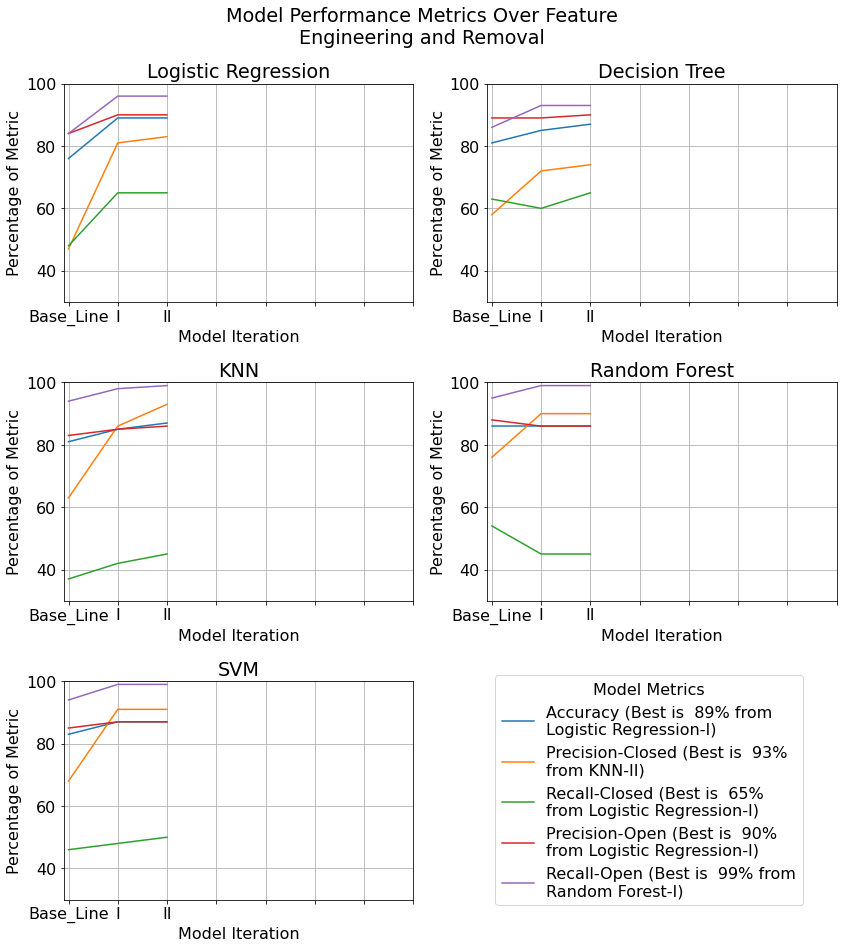

In [29]:
# run latest data against suite of models
latest_scores = split_fit_score(peak_df1, 'II')

# add latest scores to our scores data frame
scores_df = scores_df.append(pd.DataFrame(data = latest_scores,
                                          columns = scores_df.columns),
                             ignore_index = True) # must reset index for plotting legend to work

# plot our metric tracking graph
plot_model_iterations(scores_df)

As expected, there was very little chance in any of the metrics.  The great news is that none of the values decreased, and a few even increased.  Notably:
- The decision tree model saw increases in precision and recall of closed days.
- The logistic model saw an increase in the precision of closed days.
- The KNN mdoel saw an increase in the precision of closed days.

### Model Iteration III - Droping Rain/Snow Fall Flags

Based on the discussion and proof during our EDA, the rain fall and snow fall flag variables have very weak correlations with the chance of the Peak chair opening.  We are going to drop them from our data set.  Again, we are expecting littl echange in model performance.

In [30]:
# get all the day of the falg column names
flag_cols = [col for col in peak_df.columns if col.find('Flag_') != -1]

# drop flag columns and make a deep copy of the data frame
peak_df2 = peak_df1.drop(columns = flag_cols).copy(deep = True)

# check it worked
peak_df2.columns

Index(['TEMP_L0h', 'TEMP_L12h', 'TEMP_L24h', 'TEMP_L36h', 'TEMP_L48h',
       'TEMP_L60h', 'TEMP_L72h', 'TEMP_L84h', 'DWPT_L0h', 'DWPT_L12h',
       'DWPT_L24h', 'DWPT_L36h', 'DWPT_L48h', 'DWPT_L60h', 'DWPT_L72h',
       'DWPT_L84h', 'RELH_L0h', 'RELH_L12h', 'RELH_L24h', 'RELH_L36h',
       'RELH_L48h', 'RELH_L60h', 'RELH_L72h', 'RELH_L84h', 'MIXR_L0h',
       'MIXR_L12h', 'MIXR_L24h', 'MIXR_L36h', 'MIXR_L48h', 'MIXR_L60h',
       'MIXR_L72h', 'MIXR_L84h', 'SKNT_L0h', 'SKNT_L12h', 'SKNT_L24h',
       'SKNT_L36h', 'SKNT_L48h', 'SKNT_L60h', 'SKNT_L72h', 'SKNT_L84h',
       'Max Temp (°C)_L0h', 'Max Temp (°C)_L24h', 'Max Temp (°C)_L48h',
       'Max Temp (°C)_L72h', 'Min Temp (°C)_L0h', 'Min Temp (°C)_L24h',
       'Min Temp (°C)_L48h', 'Min Temp (°C)_L72h', 'Mean Temp (°C)_L0h',
       'Mean Temp (°C)_L24h', 'Mean Temp (°C)_L48h', 'Mean Temp (°C)_L72h',
       'Total Rain (mm)_L0h', 'Total Rain (mm)_L24h', 'Total Rain (mm)_L48h',
       'Total Rain (mm)_L72h', 'Total Snow (cm)_L0h', 'Tot

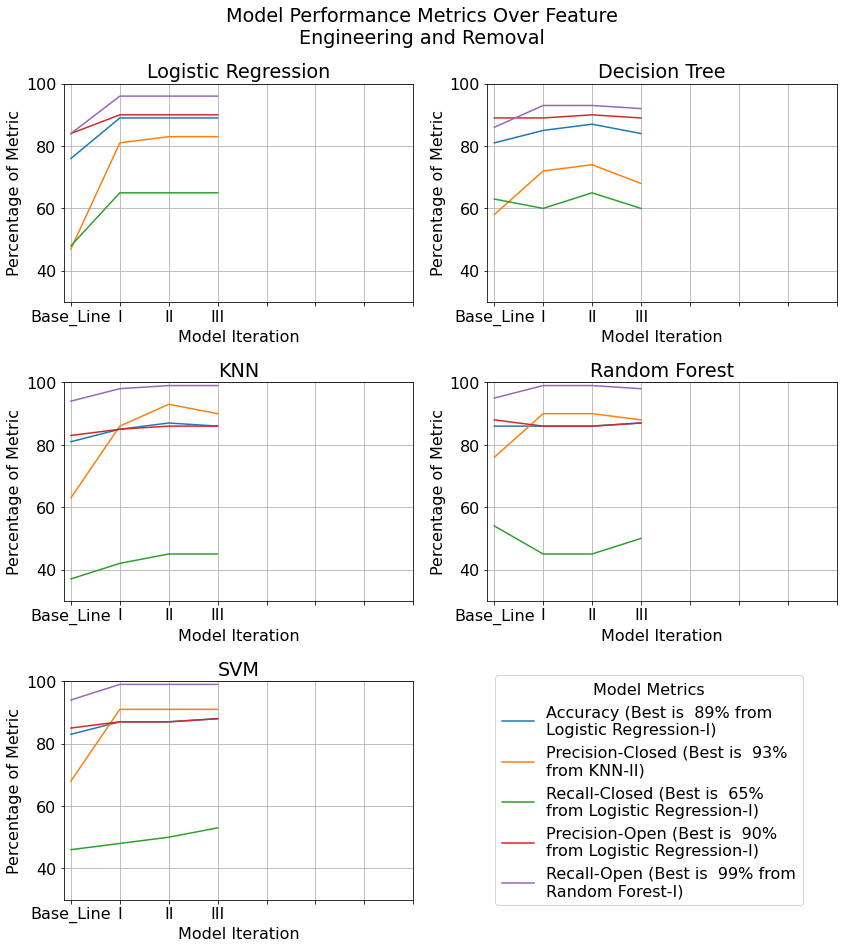

In [31]:
# run latest data against suite of models
latest_scores = split_fit_score(peak_df2, 'III')

# add latest scores to our scores data frame
scores_df = scores_df.append(pd.DataFrame(data = latest_scores,
                                          columns = scores_df.columns),
                             ignore_index = True) # must reset index for plotting legend to work

# plot our metric tracking graph
plot_model_iterations(scores_df)

As expected, over all there was little change in model performance.  Changes that did happen and are worth noting:
- The precision on closed days reduced on each of decision tree, KNN, and random forest to varying degrees
- Random forest saw an uptick in the recall on closed days
- SVM saw the recall on the closed stays continue a steady upward march.

### Model Iteration IV - Removing Snow Base Lags

As discussed in our EDA and baseline model iteration, there is a near perfect linear correlation between all of the snowpack variables.  We are going to now drop all of the snowpack lags and keep the day of measurements only.  Hopefully this will give a boost to our Linear Regression model which appears to still be our front runner.

In [32]:
# get all the day of the snowpack column names
snowpack_cols = [col for col in peak_df.columns if col.find('Snow on Grnd') != -1]

# remove day of snowpack column name from list
snowpack_cols.pop(snowpack_cols.index('Snow on Grnd (cm)_L0h'))

# drop day of snowpack columns and make a deep copy of the data frame
peak_df3 = peak_df2.drop(columns = snowpack_cols).copy(deep = True)

# check it worked
peak_df3.columns

Index(['TEMP_L0h', 'TEMP_L12h', 'TEMP_L24h', 'TEMP_L36h', 'TEMP_L48h',
       'TEMP_L60h', 'TEMP_L72h', 'TEMP_L84h', 'DWPT_L0h', 'DWPT_L12h',
       'DWPT_L24h', 'DWPT_L36h', 'DWPT_L48h', 'DWPT_L60h', 'DWPT_L72h',
       'DWPT_L84h', 'RELH_L0h', 'RELH_L12h', 'RELH_L24h', 'RELH_L36h',
       'RELH_L48h', 'RELH_L60h', 'RELH_L72h', 'RELH_L84h', 'MIXR_L0h',
       'MIXR_L12h', 'MIXR_L24h', 'MIXR_L36h', 'MIXR_L48h', 'MIXR_L60h',
       'MIXR_L72h', 'MIXR_L84h', 'SKNT_L0h', 'SKNT_L12h', 'SKNT_L24h',
       'SKNT_L36h', 'SKNT_L48h', 'SKNT_L60h', 'SKNT_L72h', 'SKNT_L84h',
       'Max Temp (°C)_L0h', 'Max Temp (°C)_L24h', 'Max Temp (°C)_L48h',
       'Max Temp (°C)_L72h', 'Min Temp (°C)_L0h', 'Min Temp (°C)_L24h',
       'Min Temp (°C)_L48h', 'Min Temp (°C)_L72h', 'Mean Temp (°C)_L0h',
       'Mean Temp (°C)_L24h', 'Mean Temp (°C)_L48h', 'Mean Temp (°C)_L72h',
       'Total Rain (mm)_L0h', 'Total Rain (mm)_L24h', 'Total Rain (mm)_L48h',
       'Total Rain (mm)_L72h', 'Total Snow (cm)_L0h', 'Tot

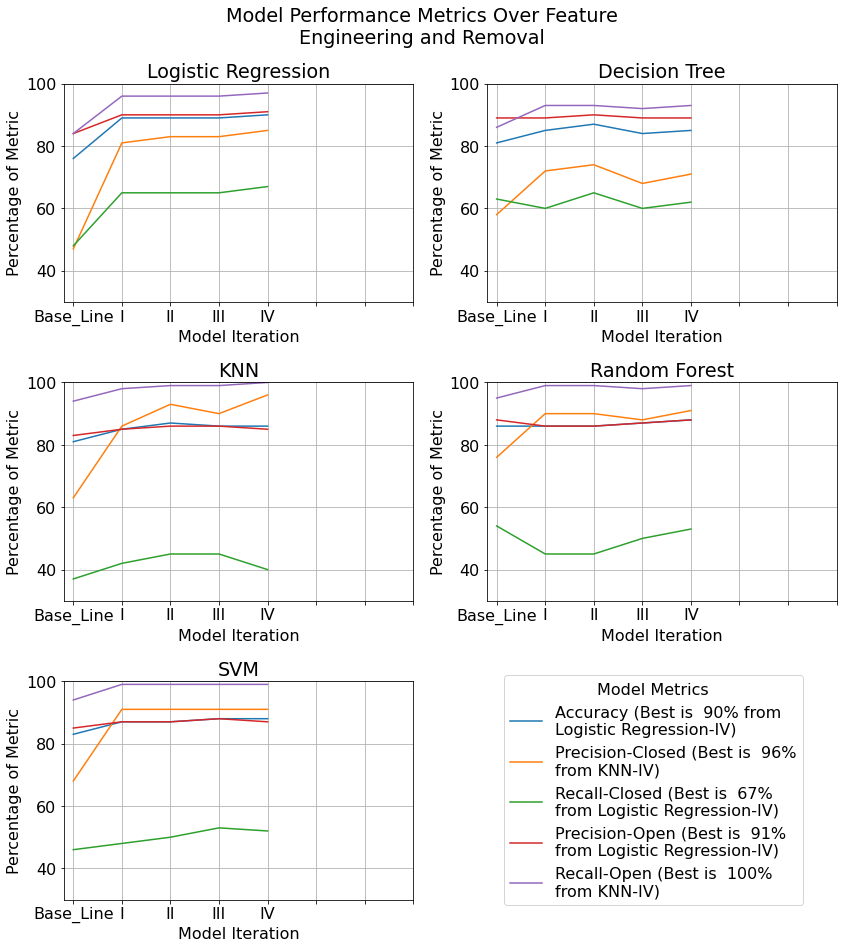

In [33]:
# run latest data against suite of models
latest_scores = split_fit_score(peak_df3, 'IV')

# add latest scores to our scores data frame
scores_df = scores_df.append(pd.DataFrame(data = latest_scores,
                                          columns = scores_df.columns),
                             ignore_index = True) # must reset index for plotting legend to work

# plot our metric tracking graph
plot_model_iterations(scores_df)

The results of dropping the lags for the snowpack have given us mostly improvements with a few blips downwards.  Notably:
- All our metrics on the logistic regression moved up slightly as was expected when removing co-linear variables.
- The KNN model shows a great visual of the trade off between precision and recall moving in opposite directions on the closed predictions.

### Model Iteration V - Engineering Snow Base Depth at 2,000m

As we saw during our EDA, the variance in the snow base depth on the day the Peak chair opened was almost 130 cm.  As discussed, that did not seem to make much sense to us.  We are going to attempt to engineer the snow depth at the mid point of the Peak chair based on the following approach:
- We will assume that 0 degrees celcius is the point at which rain becomes snow
- Using the Roundhouse/Pig Alley weather station elevation of 1640m and a mid point of [the Peak chair at 2,000m](https://whistlerplatinum.com/about-whistler/mountain-statistics/) we assume an elevation increase of 360m from the weather station to the mid point of the Peak chair
- At 100% relative humidity, the condition we have when it is raining or snowing, the temperature gradient as a function of elevation is [0.6 degrees celicus per 100m of elevation.](https://www.onthesnow.com/news/does-elevation-affect-temperature/)
- Combining the elevation change and temperature gradient we can infer a temperature at the 2,000m elevation
- We have rainfall data at the Pig Alley weather station
- If we have rain at the Pig Alley weather station and we have a temperature at the Pig Alley weather station that makes the interpolated temperature at 2,000m zero degrees celcius or lower, we can infer it is snowing at 2,000m.
- The ratio of rainfall to snow fall is an [increase in depth of 10x](https://sciencing.com/calculate-rain-snow-8344589.html).
- From our RoundhouseDataCleaningAndEDA report, we know that comparing snow fall to snow pack accumulation gives us a factor of 9/5.  This means depth of snow fall of $x$ will give an increase in snow pack of approximately $\frac{5}{9}x$
- Finally, for days where it rained, and the interpolated temperature is greater than 0 degress celcius, we will look at the reduction in snow pack at the Roundhouse elevation and assume the same amount of melting happened due to rain at the 2,000m elevation.

We do have to make one unforunate assumption.  Because we have discarded data earlier than the first date of the ski season, we will have to assume the snowpack depth on the first day of the season is uniform at all elevations.  We could go and get more data to make a more accurate prediction, but let's see how much this tightens up the variance in snow pack on the first day the Peak opens and how that affects our models first.

Another point that is worth some discussion.  As outlined above, in order to interpolate snow pack depth, we are interpolating temperature, snow fall, and rain fall at the 2,000m elevation.  The question is, should be update all of these variables as well as the snowpack depth to have our measurements be at an infered elevation of 2,000m?  If we were to do this, we would have to do it for all of the lag values as well to ensure that the lag temperatures were giving values at the same elevation as the day of values.  In this case, it would have made much more sense to do this interpolation upstream.  So why won't we do this?  These numbers we interpolate would all be estimates as opposed to actuals.  We are in favour of keeping the true measured values we have as opposed to replacing measurements with estimates.

Let's define a function to do the interpolation for us, then add our new snow pack depth columns (one for each lag day), drop the snow pack old columns, visualize the variance, and run the new columns through our model.

In [34]:
# get copy of df to work with
peak_df4 = peak_df3.copy(deep = True)

# create a temporary column that gives us the difference between
# snow on the ground today and snow on the ground yesterday.
peak_df4['snowpack_diff'] = -1*peak_df4['Snow on Grnd (cm)_L0h'].diff(periods = -1)

In [35]:
def interpolate_snowpack_contribution(mean_temp, snowpack_diff, snowfall, rainfall):
    """
    Takes mean temperature, snowpack_difference, snowfall, and rain fall from our peak data 
    frame and interpolates the snowpack difference at 2,000m as per above outline.  Returns
    the adjusted snowpack difference.
    """
    # calculate temperature at 2,000m
    temp_2000 = mean_temp - (0.6 * 360/100)

    # if it is raining everywhere or if it is snowing everywhere
    if (temp_2000 > 0) or (mean_temp <= 0) :
        
        # assume snow pack difference at 1,640m and 2,000m is equal
        snowpack_diff = snowpack_diff
            
    # else assume snow at peak all day, and rain possibly mixed with snow at roundhouse
    else:

        # calculate snowfall for that day - if it snowed at roundhouse it snowed at peak,
        # but if it rained at roundhouse assume it snowed at peak as per adjusted temp.
        snowfall = snowfall + (rainfall * 10/10) # 10x height in mm, then convert to cm
        
        # calculate increase in snow pack for that day
        snowpack_diff = snowfall * 5/9
    
    return round(snowpack_diff, 1)

In [36]:
# calculate adjusted snowpack difference
peak_df4['adjusted snowpack_diff'] = peak_df4.apply(lambda x: interpolate_snowpack_contribution(x['Mean Temp (°C)_L0h'], x['snowpack_diff'],
                                                           x['Total Snow (cm)_L0h'], x['Total Rain (mm)_L0h']),
               axis = 1)

In [37]:
# calculate adjusted snow on ground - create column first with mid-mountain snow pack
# this will allow us to keep the values for the first day of each season
peak_df4['Adjusted Snow on Grnd'] = peak_df4['Snow on Grnd (cm)_L0h']

# get index in a list
index_list = list(peak_df4.index)

# loop through each each row except the last row
for i, idx in enumerate(index_list[:-1]):
    
    # check to see if the next record is in the next season
    if (index_list[i + 1] - idx) > timedelta(days = 30):
        
        # skip this iteration - we don't want to accumulate snow over seasons!
        pass
    
    else:
        # set next rows adjusted snow on ground value based on this rows plus adjusted difference
        peak_df4.loc[index_list[i + 1], 'Adjusted Snow on Grnd'] = peak_df4.loc[idx, 'Adjusted Snow on Grnd'] + peak_df4.loc[idx, 'adjusted snowpack_diff']

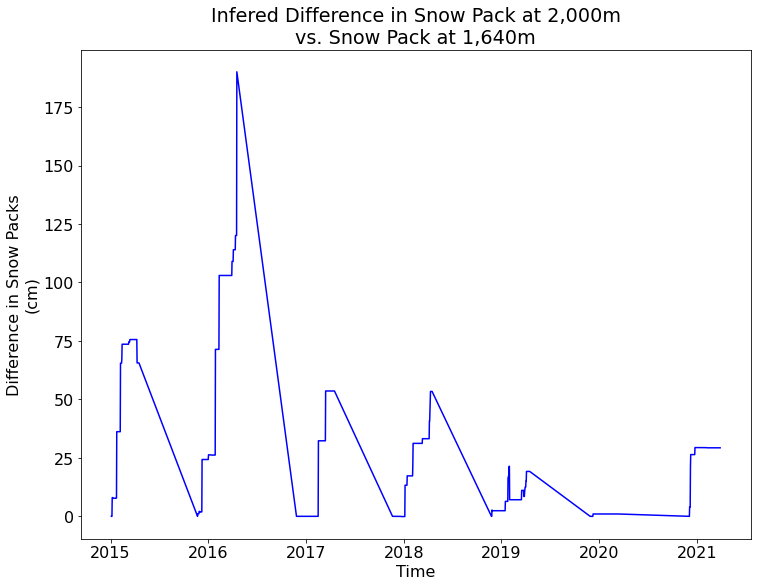

In [38]:
# check to see how different our snow packs are

# set figure size
plt.figure(figsize = (12,9))

# plot data
plt.plot(peak_df4['Adjusted Snow on Grnd'] - peak_df4['Snow on Grnd (cm)_L0h'], color = 'blue')

# add titles, labels
plt.title('Infered Difference in Snow Pack at 2,000m\nvs. Snow Pack at 1,640m')
plt.xlabel('Time')
plt.ylabel('Difference in Snow Packs\n(cm)')

plt.show()

The above chart shows the difference in our known snow pack and our inferred snow pack.  It is interesting that the 2019/2020 ski season has almost no variability.  Let's to a quick check on the mean temperatures in that season to make sure nothing is going amiss.

In [39]:
peak_df4[(peak_df4.index > datetime(2019, 10, 1).date()) &
         (peak_df4.index < datetime(2020, 4, 30).date())]['Mean Temp (°C)_L0h'].describe()

count    107.000000
mean      -5.445794
std        3.615148
min      -18.800000
25%       -7.300000
50%       -4.800000
75%       -2.800000
max        0.500000
Name: Mean Temp (°C)_L0h, dtype: float64

From the above, it looks like most of the temperatures for the 2019/2020 season were below -2.8 degrees celcius and the max average daily temperature reached during the season was only 0.5 degrees!  This implies there were very few opportunities for it to be raining at 1,640m while snowing at 2,000m.

From our EDA and Modelling Report we know the opening days for each year of the peak chair.  Let's use those to take a look the variance in adjusted snowpack on those opening days.

In [40]:
# enter list of opening days
opening_days = ['2016-11-30', '2017-12-02', '2018-12-01', '2020-01-14', '2020-12-05']

# convert opening dates to type datetime.date so it can be used to pull from the date index in the df
opening_days = [datetime.strptime(date, '%Y-%m-%d').date() for date in opening_days]

# display df filtered for opening days.
peak_df4.loc[opening_days, ['Adjusted Snow on Grnd']]

,Adjusted Snow on Grnd
2016-11-30,178.0
2017-12-02,159.0
2018-12-01,70.4
2020-01-14,195.0
2020-12-05,92.0


The results of the work have made little difference to the spread in snowpack depths on the opening day of the Peak chair.  As stated earlier, because we have limited the data to the start date of the ski season, not when the snow started falling in a given fall/winter, we had to assume uniform snowfall over the mountain up to the point of opening day.  We do have the original weather station records for the preseason, but on further investigation, those records are all full of missing values.  Unfortunately, that means our attempt to engineer the snowpack at 2,000m is not going to work.

Moving on, let's take a look to see if there is anything else in our data we think might be worth dropping.  Before we do that, we are going to remove the additional columns we added to the dataframe while trying to interpolate the snowpack.

In [41]:
# drop columns created for interpolation
peak_df4.drop(columns = ['snowpack_diff', 'adjusted snowpack_diff', 'Adjusted Snow on Grnd'], inplace = True)

In [42]:
# confirm columns dropped and look for more to drop
peak_df4.columns

Index(['TEMP_L0h', 'TEMP_L12h', 'TEMP_L24h', 'TEMP_L36h', 'TEMP_L48h',
       'TEMP_L60h', 'TEMP_L72h', 'TEMP_L84h', 'DWPT_L0h', 'DWPT_L12h',
       'DWPT_L24h', 'DWPT_L36h', 'DWPT_L48h', 'DWPT_L60h', 'DWPT_L72h',
       'DWPT_L84h', 'RELH_L0h', 'RELH_L12h', 'RELH_L24h', 'RELH_L36h',
       'RELH_L48h', 'RELH_L60h', 'RELH_L72h', 'RELH_L84h', 'MIXR_L0h',
       'MIXR_L12h', 'MIXR_L24h', 'MIXR_L36h', 'MIXR_L48h', 'MIXR_L60h',
       'MIXR_L72h', 'MIXR_L84h', 'SKNT_L0h', 'SKNT_L12h', 'SKNT_L24h',
       'SKNT_L36h', 'SKNT_L48h', 'SKNT_L60h', 'SKNT_L72h', 'SKNT_L84h',
       'Max Temp (°C)_L0h', 'Max Temp (°C)_L24h', 'Max Temp (°C)_L48h',
       'Max Temp (°C)_L72h', 'Min Temp (°C)_L0h', 'Min Temp (°C)_L24h',
       'Min Temp (°C)_L48h', 'Min Temp (°C)_L72h', 'Mean Temp (°C)_L0h',
       'Mean Temp (°C)_L24h', 'Mean Temp (°C)_L48h', 'Mean Temp (°C)_L72h',
       'Total Rain (mm)_L0h', 'Total Rain (mm)_L24h', 'Total Rain (mm)_L48h',
       'Total Rain (mm)_L72h', 'Total Snow (cm)_L0h', 'Tot

The three items that pop out as targets for removing colinearity are the max/min/mean temperatures from the pig alley weather station.  Let's drop the min and max temperatures to see if that provides any improvement to our model

In [43]:
# get all the day of the min/max temp column names
min_max_cols = [col for col in peak_df4.columns if ((col.find('Min Temp') != -1) |
                                                   (col.find('Max Temp') != -1))]

# drop min/max columns
peak_df4 = peak_df4.drop(columns = min_max_cols)

# check it worked
peak_df4.columns

Index(['TEMP_L0h', 'TEMP_L12h', 'TEMP_L24h', 'TEMP_L36h', 'TEMP_L48h',
       'TEMP_L60h', 'TEMP_L72h', 'TEMP_L84h', 'DWPT_L0h', 'DWPT_L12h',
       'DWPT_L24h', 'DWPT_L36h', 'DWPT_L48h', 'DWPT_L60h', 'DWPT_L72h',
       'DWPT_L84h', 'RELH_L0h', 'RELH_L12h', 'RELH_L24h', 'RELH_L36h',
       'RELH_L48h', 'RELH_L60h', 'RELH_L72h', 'RELH_L84h', 'MIXR_L0h',
       'MIXR_L12h', 'MIXR_L24h', 'MIXR_L36h', 'MIXR_L48h', 'MIXR_L60h',
       'MIXR_L72h', 'MIXR_L84h', 'SKNT_L0h', 'SKNT_L12h', 'SKNT_L24h',
       'SKNT_L36h', 'SKNT_L48h', 'SKNT_L60h', 'SKNT_L72h', 'SKNT_L84h',
       'Mean Temp (°C)_L0h', 'Mean Temp (°C)_L24h', 'Mean Temp (°C)_L48h',
       'Mean Temp (°C)_L72h', 'Total Rain (mm)_L0h', 'Total Rain (mm)_L24h',
       'Total Rain (mm)_L48h', 'Total Rain (mm)_L72h', 'Total Snow (cm)_L0h',
       'Total Snow (cm)_L24h', 'Total Snow (cm)_L48h', 'Total Snow (cm)_L72h',
       'Snow on Grnd (cm)_L0h', 'day_status_L0h', 'day_status_L24h',
       'day_status_L48h', 'day_status_L72h', 'sin_D

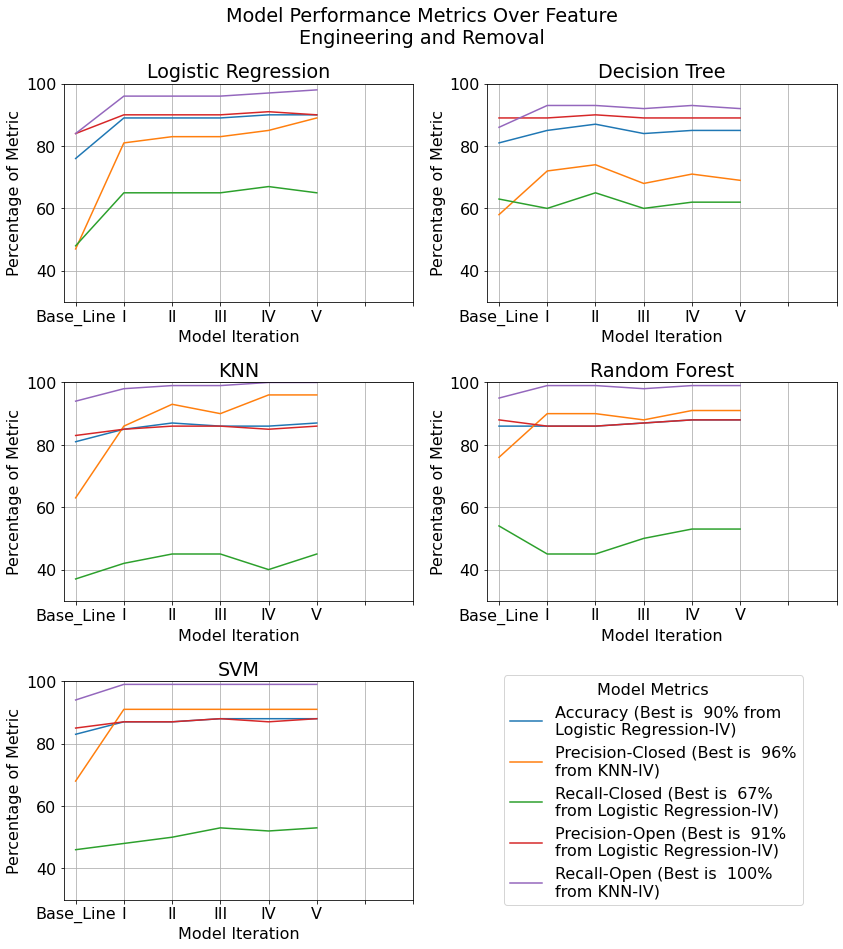

In [44]:
# run latest data against suite of models
latest_scores = split_fit_score(peak_df4, 'V')

# add latest scores to our scores data frame
scores_df = scores_df.append(pd.DataFrame(data = latest_scores,
                                          columns = scores_df.columns),
                             ignore_index = True) # must reset index for plotting legend to work

# plot our metric tracking graph
plot_model_iterations(scores_df)

### Model Iteration VI - Upsampling

Throughout our model iterations so far, we have had a tough time getting much movement on the recall score with regards to the days the Peak chair is closed.  Out of the closed days, we are classifying too many of them as open.  We do have somewhat of a class imbalance of roughly 3:1, so let's double the number of closed days in our data set via upsampling to see what kind of effect that has.

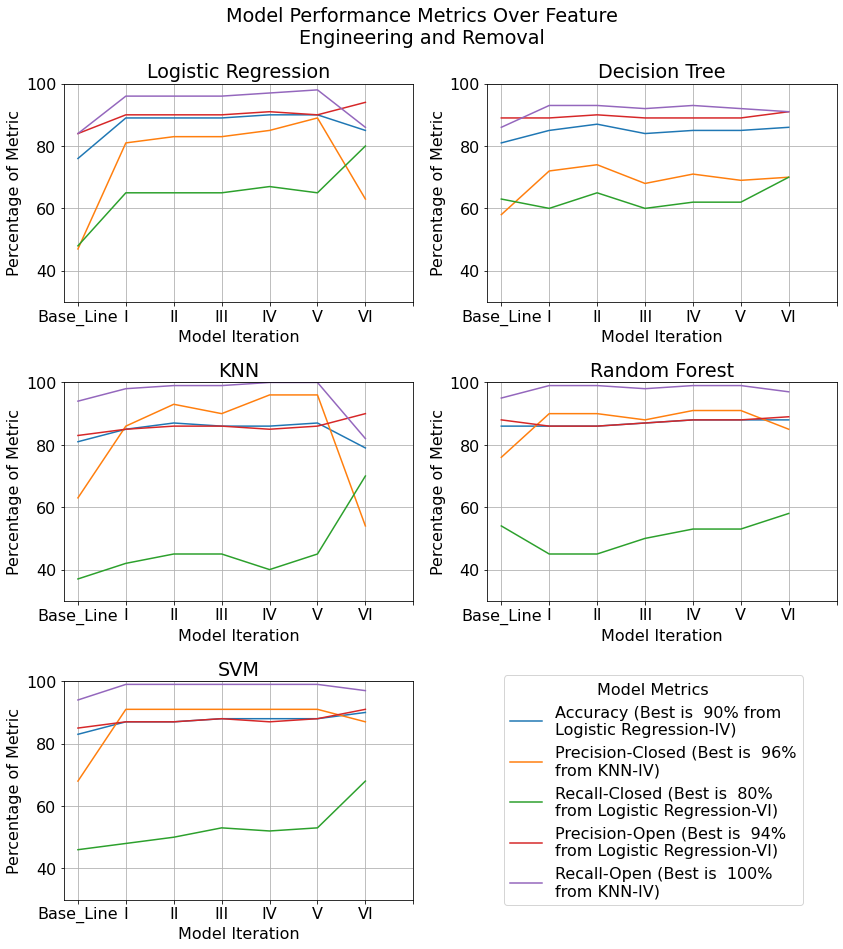

In [45]:
# run latest data against suite of models
latest_scores = split_fit_score(peak_df4, 'VI', upsample = True)

# add latest scores to our scores data frame
scores_df = scores_df.append(pd.DataFrame(data = latest_scores,
                                          columns = scores_df.columns),
                             ignore_index = True) # must reset index for plotting legend to work

# plot our metric tracking graph
plot_model_iterations(scores_df)

From the above plots, we can see that the upsampling has had some pretty drastic effects on our two leading models, Logistic Regression and KNN.  We have accomplished a 13 percentage point jump in the recall on our closed days.  This has cost us drastically with regards to our precision on the closed days.  The results of this of leading us further towards implementing a stacked model approach.

### Model Iteration VII - Selecting and Optimizing Models

From our model scores above, we can see that our two best performing models are our Logistic Regression and our KNN models.  We will move forward with these two models and optimize their hyperparameters to try and gain a little more performance.  We will do this by utilizing cross validation using 5 folds.  This is the standard set by sklearn and we have no reason to deviate from it.

We will be running a series of five different optimizations, one for each of the metrics we have been tracking.  The models, data-sets, and metrics will be matched as per the Model Metrics legend in the above figure.  The goal here is to produce a model that is best at each metric, and from there, stack them using sklearn's ensemble stacking classifier.

#### Model Iteration VII - Accuracy on Logistic Regression and Model Iteration IV Data 

Let's start by optimizing the parameters of our over accuracy on our Logistic Regression model.  We will iterate over the solver/penalty combinations of `lbfgs-l2`, `liblinear-l1`, and `liblinear-l2`.  We will also iterate over a range of `C` values (inverse regulariation strength) to be used with each of the regularization functions.  We will start with a wide net for this and then reduce it down for a more granular search.

In [46]:
# split data in to dependent and independent variables using data from model IV
X = peak_df3.drop(columns = ['day_status_L0h'])
y = peak_df3['day_status_L0h']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)

# fit scaler on train data and transform
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# scale test data
X_test_scaled = scaler.transform(X_test)

In [47]:
# dictionary of solver/regularization penalty combinations
params = [['lbfgs', 'l2'],
          ['liblinear', 'l1'],
          ['liblinear', 'l2']]

# generate wide range of C values
C_values = 10.0**np.arange(-10, 10, 1)

# store the results in dictionary where each value is an array of cross val scores for each
# param set
cross_val_scores = {}

# loop through all of all parameter combinations
for solver, penalty in params:
    
    # array to store cross val scores for each c-value
    cross_val_c_scores = []
    
    # loop through each c value
    for c in C_values:
        
        # instantiate model
        logmod = LogisticRegression(penalty = penalty, C = c, solver = solver, max_iter = 10000)
        
        # score the model on 5 fold cross validation
        cv_score = np.mean(cross_val_score(logmod, X_train_scaled, y_train, cv = 5, n_jobs = 8))
        
        # add this runs scores to our scores array
        cross_val_c_scores.append(cv_score)
    
    # add this solver-penalty combos scores to our dictionary
    cross_val_scores[f"{solver}-{penalty}"] = cross_val_c_scores

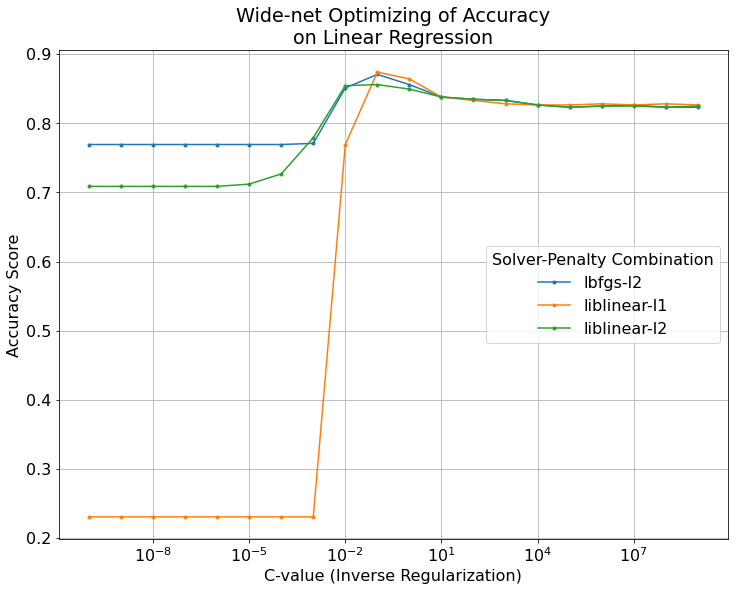

In [48]:
# plot all of our cross val scores
plt.figure(figsize = (12,9))

# plot each solver-penalty combo as its own line
for solver, penalty in params:
    plt.plot(C_values,
             cross_val_scores[f"{solver}-{penalty}"],
             label = f"{solver}-{penalty}",
             marker = '.')

# add legend and grid
plt.legend(title = 'Solver-Penalty Combination',
           loc = 'center right')
plt.grid()

# set x-scale to logarithmic
plt.xscale("log")

# add title and axis legends
plt.title('Wide-net Optimizing of Accuracy\non Linear Regression')
plt.xlabel('C-value (Inverse Regularization)')
plt.ylabel('Accuracy Score')

plt.show()

From the above it looks like our best regularization value for each model is between 0.01 and 1.  Let's tighten up our range of C values and run the optimization again.

In [49]:
# dictionary of solver/regularization penalty combinations
params = [['lbfgs', 'l2'],
          ['liblinear', 'l1'],
          ['liblinear', 'l2']]

# generate a tight range of C values
C_values = 10.0**np.arange(-2, 1, 0.1)

# store the results in dictionary where each value is an array of cross val scores for each
# param set
cross_val_scores = {}

# loop through all of all parameter combinations
for solver, penalty in params:
    
    # array to store cross val scores for each c-value
    cross_val_c_scores = []
    
    # loop through each c value
    for c in C_values:
        
        # instantiate model
        logmod = LogisticRegression(penalty = penalty,
                                    C = c,
                                    solver = solver,
                                    max_iter = 10000)
        
        # score the model on 5 fold cross validation
        cv_score = np.mean(cross_val_score(logmod, X_train_scaled, y_train, cv = 5, n_jobs = 8))
        
        # add this runs scores to our scores array
        cross_val_c_scores.append(cv_score)
    
    # add this solver-penalty combos scores to our dictionary
    cross_val_scores[f"{solver}-{penalty}"] = cross_val_c_scores

In [50]:
# store solver-penalty best score and c value , initialized to zeros
best_result = {'solver-penalty': 0,
               'c-val': 0,
               'score': 0}

# loop through param combinatinos
for solver, penalty in params:
    
    # get the best score/c-value combo
    best_score_c = max(zip(cross_val_scores[f"{solver}-{penalty}"], C_values))
    
    # store the new result if it is the best
    if best_result['score'] < best_score_c[0]:
        best_result['solver-penalty'] = f"{solver}-{penalty}"
        best_result['c-val'] = best_score_c[1]
        best_result['score'] = best_score_c[0]

In [51]:
# dictionary to store the metric/model name/hyperparameters
metric_info_for_optimizing = {'accuracy':{'model': 'Logistic Regression',
                                          'hyperparameters': best_result}}

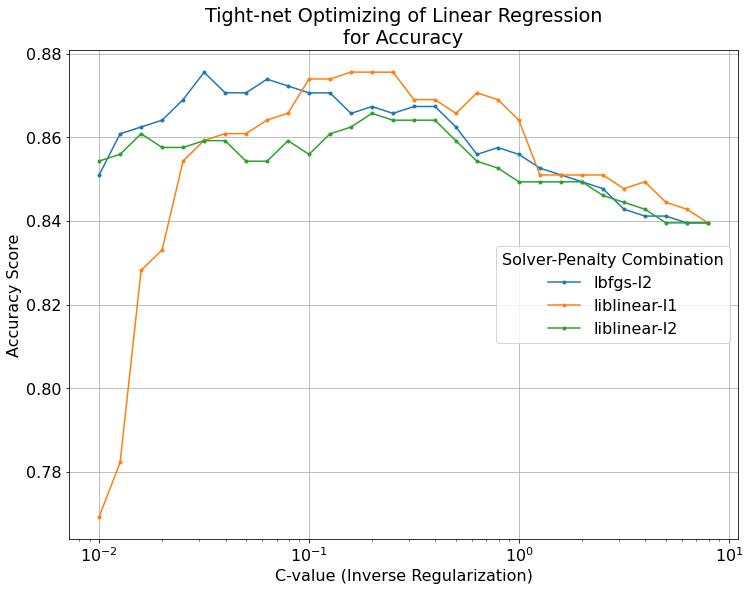

In [52]:
# plot all of our cross val scores
plt.figure(figsize = (12,9))

# plot each solver-penalty combo as its own line
for solver, penalty in params:
    plt.plot(C_values,
             cross_val_scores[f"{solver}-{penalty}"],
             label = f"{solver}-{penalty}",
             marker = '.')

# add legend and grid
plt.legend(title = 'Solver-Penalty Combination',
           loc = 'center right')
plt.grid()

# set x-scale to logarithmic
plt.xscale("log")

# add title and axis legends
plt.title('Tight-net Optimizing of Linear Regression\nfor Accuracy')
plt.xlabel('C-value (Inverse Regularization)')
plt.ylabel('Accuracy Score')

plt.show()

In [53]:
# print out our best c-val and score
print(best_result)

{'solver-penalty': 'liblinear-l1', 'c-val': 0.15848931924611173, 'score': 0.8755964280954285}


The above plot and output show us that our best solver is the liblinear with a regularization function l1 (lasso regression) and a c-value of 0.158489.  The good news is that this shows a gain of almost 1.5 percentage points in accuacy over a c-value of 1, which is the default value that was used in our previous model iterations.

#### Model Iteration VII - Closed Precision on KNN and Model Iteration IV Data

For our KNN classifier, the only parameter we will be optimizing for is the number of neighbours.  Considering that our number of total observations is roughly 850, we will set our number of neighbours to run from 1 through 30.  Here, we can re-use the train/test/split data sets from the accuracy section above as the data set is the same.

We do need to make a few changes as we move through this process though.  First, we need to pass the `precision` evaluation metric to the `scoring` argument of the `cross_val_score` method.  This will allow us to maximize this model for precision instead of accuracy.  Second, as per the [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score), precision is calculated as `True Positive / (True Positive + False Positive)`.  In this case, because we are evaluating for precision on our closed variable, we want `True Negative / (True Negative + False Negative)`.  To accomplish this, we need to set the `pos_label` argument of `cross_val_score` to 0.  This will cause our closed precision to be evaluated as opposed to our open prcision.

In [54]:
# store cross val scores
cross_val_scores = []

# set range of n_neighbours
n_neighbours = np.arange(1, 31, 1)

# define our callable scorer object using sklearn make scorer
closed_precision_scorer = make_scorer(precision_score, pos_label = 0)

# loop through various number of neighbours
for n in n_neighbours:
    
    # instantiate the model
    knn = KNeighborsClassifier(n_neighbors = n)
    
    # score the model on 5 fold cross validation
    cv_score = np.mean(cross_val_score(knn,
                                       X_train_scaled,
                                       y_train,
                                       cv = 5,
                                       n_jobs = 8,
                                       scoring = closed_precision_scorer))
    
    # store the score in our array
    cross_val_scores.append(cv_score)

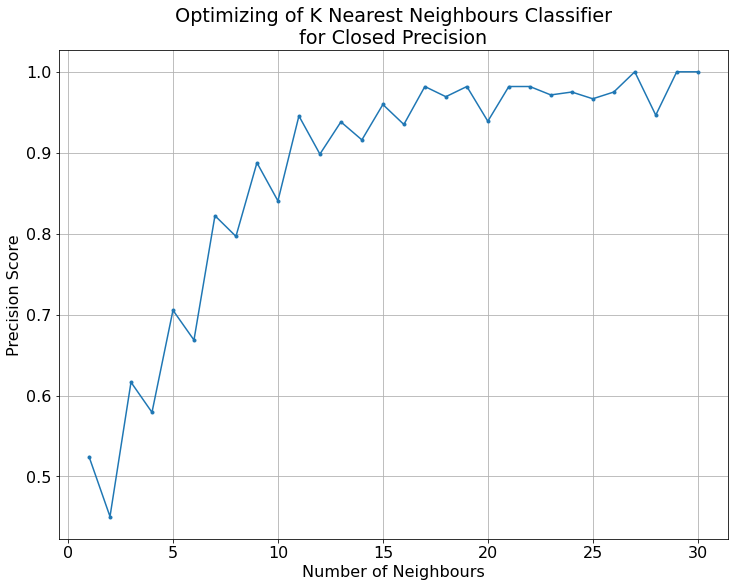

In [55]:
# plot all of our cross val scores
plt.figure(figsize = (12,9))

# plot our scores
plt.plot(n_neighbours,
         cross_val_scores,
         marker = '.')

# add  grid
plt.grid()

# add title and axis legends
plt.title('Optimizing of K Nearest Neighbours Classifier\nfor Closed Precision')
plt.xlabel('Number of Neighbours')
plt.ylabel('Precision Score')

plt.show()

In [56]:
# show us the max score/neighbour combination
max(zip(cross_val_scores, n_neighbours))

(1.0, 30)

In [57]:
# store info for later optimizing
metric_info_for_optimizing['closed_precision'] = {'model': 'KNN',
                                                  'hyperparameters': {'n_neighbours': 17}}

From the chart and output above, we can see that our best score comes with number of neighbours equal to 30.  This is a great score for our goal, but it also makes us think that the approach we have laid out may not be the best.  To try and combat some possible over fitting, we have selected 17 as our number of neighbours.  We will push ahead anyway and see what the results are.

#### Model Iteration VII - Open Recall on KNN and Model Iteration IV Data

We are going to jump out of order of our Model Metrics table to save a small bit of setup.  Since the open recall best model is a KNN on the same data set we have been using, we are going to run the open recall optimization now.  again, we will use number of neighbours from 1 to 30.  Here, we will set the `scoring` arument to `recall_score`. 

In [58]:
# store cross val scores
cross_val_scores = []

# set range of n_neighbours
n_neighbours = np.arange(1, 31, 1)

# define our callable scorer object using sklearn make scorer
open_recall_scorer = make_scorer(recall_score, pos_label = 1)

# loop through various number of neighbours
for n in n_neighbours:
    
    # instantiate the model
    knn = KNeighborsClassifier(n_neighbors = n)
    
    # score the model on 5 fold cross validation
    cv_score = np.mean(cross_val_score(knn,
                                       X_train_scaled,
                                       y_train,
                                       cv = 5,
                                       n_jobs = 8,
                                       scoring = open_recall_scorer))
    
    # store the score in our array
    cross_val_scores.append(cv_score)

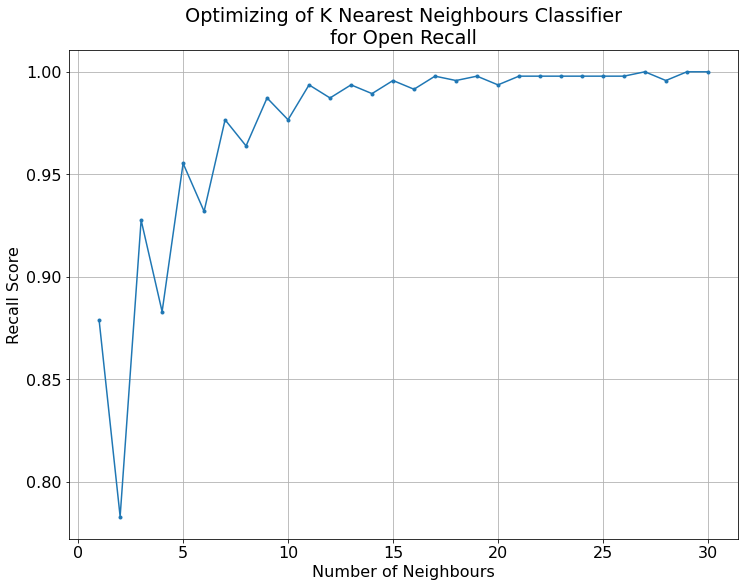

In [59]:
# plot all of our cross val scores
plt.figure(figsize = (12,9))

# plot our scores
plt.plot(n_neighbours,
         cross_val_scores,
         marker = '.')

# add  grid
plt.grid()

# add title and axis legends
plt.title('Optimizing of K Nearest Neighbours Classifier\nfor Open Recall')
plt.xlabel('Number of Neighbours')
plt.ylabel('Recall Score')

plt.show()

In [60]:
# show us the max score/neighbour combination
max(zip(cross_val_scores, n_neighbours))

(1.0, 30)

In [61]:
# store info for later optimizing
metric_info_for_optimizing['open_recall'] = {'model': 'KNN',
                                             'hyperparameters': {'n_neighbours': 17}}

Looking at are chart above, our best score comes with then number of neighbours equal to 30.  Again, we feel like this is getting into slightly overfitted territory, so we are going to go with a value of 17 neighbours again.

#### Model Iteration VII - Closed Recall on Logistic Regression and Model Iteration VI Data

We will iterate over the solver/penalty combinations of `lbfgs-l2`, `liblinear-l1`, and `liblinear-l2`.  We will also iterate over a range of `C` values (inverse regulariation strength) to be used with each of the regularization functions.  We will start with a wide net for this and then reduce it down for a more granular search.

Further, we will also use the scoring function `recall_score` with the `pos_label` agrument set to 0.  We will need to generate a new train/test set as we are now working with the data from iteration VI, and that will include running an up-sampling.

In [62]:
# split data in to dependent and independent variables using data from model VI
X = peak_df4.drop(columns = ['day_status_L0h'])
y = peak_df4['day_status_L0h']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)

# generate additional samples by making perfectly balanced classes
X_upsampled, y_upsampled = resample(X_train[y_train == 0],
                                    y_train[y_train == 0],
                                    replace = True,
                                    n_samples = X_train[y_train == 1].shape[0],
                                    random_state = 42)

# combine upsamples with original data so classes are balanced
X_train = np.vstack((X_train[y_train == 1], X_upsampled))
y_train = np.hstack((y_train[y_train == 1], y_upsampled))

# fit scaler on train data and transform
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# scale test data
X_test_scaled = scaler.transform(X_test)

In [63]:
# dictionary of solver/regularization penalty combinations
params = [['lbfgs', 'l2'],
          ['liblinear', 'l1'],
          ['liblinear', 'l2']]

# generate wide range of C values
C_values = 10.0**np.arange(-10, 10, 1)

# store the results in dictionary where each value is an array of cross val scores for each
# param set
cross_val_scores = {}

# define our callable scorer object using sklearn make scorer
closed_recall_scorer = make_scorer(recall_score, pos_label = 0)


# loop through all of all parameter combinations
for solver, penalty in params:
    
    # array to store cross val scores for each c-value
    cross_val_c_scores = []
    
    # loop through each c value
    for c in C_values:
        
        # instantiate model
        logmod = LogisticRegression(penalty = penalty, C = c, solver = solver, max_iter = 10000)
        
        # score the model on 5 fold cross validation
        cv_score = np.mean(cross_val_score(logmod,
                                           X_train_scaled,
                                           y_train,
                                           cv = 5,
                                           n_jobs = 8,
                                           scoring = closed_recall_scorer))
        
        # add this runs scores to our scores array
        cross_val_c_scores.append(cv_score)
    
    # add this solver-penalty combos scores to our dictionary
    cross_val_scores[f"{solver}-{penalty}"] = cross_val_c_scores

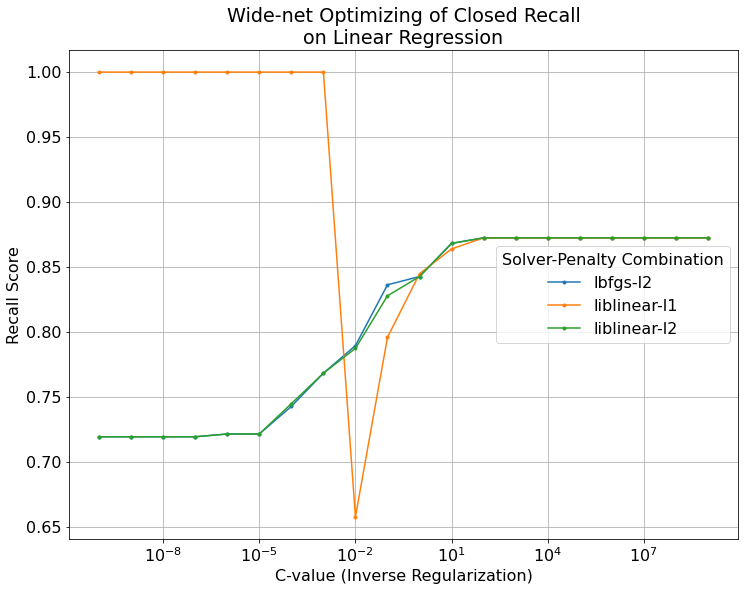

In [64]:
# plot all of our cross val scores
plt.figure(figsize = (12,9))

# plot each solver-penalty combo as its own line
for solver, penalty in params:
    plt.plot(C_values,
             cross_val_scores[f"{solver}-{penalty}"],
             label = f"{solver}-{penalty}",
             marker = '.')

# add legend and grid
plt.legend(title = 'Solver-Penalty Combination',
           loc = 'center right')
plt.grid()

# set x-scale to logarithmic
plt.xscale("log")

# add title and axis legends
plt.title('Wide-net Optimizing of Closed Recall\non Linear Regression')
plt.xlabel('C-value (Inverse Regularization)')
plt.ylabel('Recall Score')

plt.show()

From the above, it looks like we have some serious over fitting for the liblinear-l1 model in the lower C values.  Let's focus in on the 1 through 100 C values and see where our optimal model is.

In [65]:
# dictionary of solver/regularization penalty combinations
params = [['lbfgs', 'l2'],
          ['liblinear', 'l1'],
          ['liblinear', 'l2']]

# generate wide range of C values
C_values = 10.0**np.arange(0, 2, .1)

# store the results in dictionary where each value is an array of cross val scores for each
# param set
cross_val_scores = {}

# define our callable scorer object using sklearn make scorer
closed_recall_scorer = make_scorer(recall_score, pos_label = 0)

# loop through all of all parameter combinations
for solver, penalty in params:
    
    # array to store cross val scores for each c-value
    cross_val_c_scores = []
    
    # loop through each c value
    for c in C_values:
        
        # instantiate model
        logmod = LogisticRegression(penalty = penalty, C = c, solver = solver, max_iter = 10000)
        
        # score the model on 5 fold cross validation
        cv_score = np.mean(cross_val_score(logmod,
                                           X_train_scaled,
                                           y_train,
                                           cv = 5,
                                           n_jobs = 8,
                                           scoring = closed_recall_scorer))
        
        # add this runs scores to our scores array
        cross_val_c_scores.append(cv_score)
    
    # add this solver-penalty combos scores to our dictionary
    cross_val_scores[f"{solver}-{penalty}"] = cross_val_c_scores

In [66]:
# store solver-penalty best score and c value , initialized to zeros
best_result = {'solver-penalty': 0,
               'c-val': 0,
               'score': 0}

# loop through param combinatinos
for solver, penalty in params:
    
    # get the best score/c-value combo
    best_score_c = max(zip(cross_val_scores[f"{solver}-{penalty}"], C_values))
    
    # store the new result if it is the best
    if best_result['score'] < best_score_c[0]:
        best_result['solver-penalty'] = f"{solver}-{penalty}"
        best_result['c-val'] = best_score_c[1]
        best_result['score'] = best_score_c[0]

In [67]:
# dictionary to store the metric/model name/data frame/hyperparameters
metric_info_for_optimizing['closed_recall'] = {'model': 'Logistic Regression',
                                                'hyperparameters': best_result}

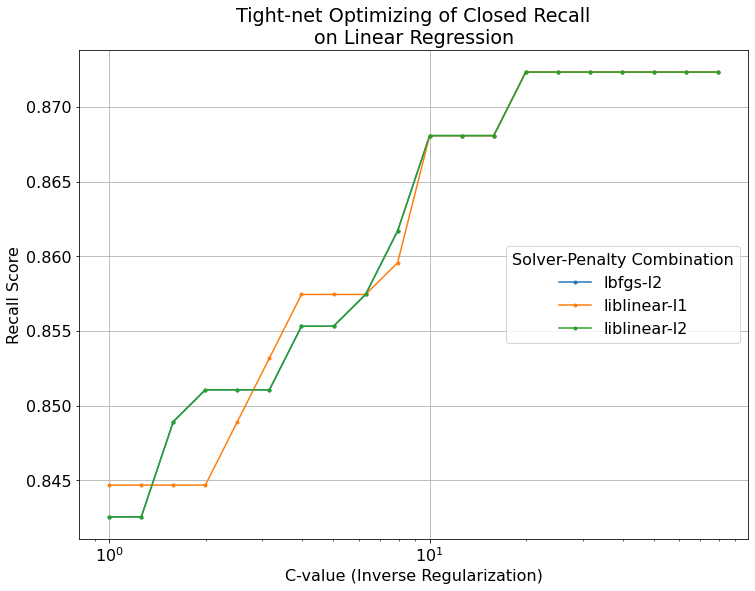

In [68]:
# plot all of our cross val scores
plt.figure(figsize = (12,9))

# plot each solver-penalty combo as its own line
for solver, penalty in params:
    plt.plot(C_values,
             cross_val_scores[f"{solver}-{penalty}"],
             label = f"{solver}-{penalty}",
             marker = '.')

# add legend and grid
plt.legend(title = 'Solver-Penalty Combination',
           loc = 'center right')
plt.grid()

# set x-scale to logarithmic
plt.xscale("log")

# add title and axis legends
plt.title('Tight-net Optimizing of Closed Recall\non Linear Regression')
plt.xlabel('C-value (Inverse Regularization)')
plt.ylabel('Recall Score')

plt.show()

In [69]:
# print out our best c-val and score
print(best_result)

{'solver-penalty': 'lbfgs-l2', 'c-val': 79.43282347242817, 'score': 0.8723404255319149}


The above plot and output shows our best model scorer is lbfgs with l2 regularization and a score of 87.2%.

#### Model Iteration VII - Open Precision on Logistic Regression and Model Iteration VI Data

For our final optimization, we will iterate over the solver/penalty combinations of `lbfgs-l2`, `liblinear-l1`, and `liblinear-l2`.  We will also iterate over a range of `C` values (inverse regulariation strength) to be used with each of the regularization functions.  We will start with a wide net for this and then reduce it down for a more granular search.

Further, we will also use the scoring function `precision_score` with the `pos_label` agrument set to 1.  We can use the same train/test set as the last data was from iteration VI.

In [70]:
# dictionary of solver/regularization penalty combinations
params = [['lbfgs', 'l2'],
          ['liblinear', 'l1'],
          ['liblinear', 'l2']]

# generate wide range of C values
C_values = 10.0**np.arange(-10, 10, 1)

# store the results in dictionary where each value is an array of cross val scores for each
# param set
cross_val_scores = {}

# define our callable scorer object using sklearn make scorer
open_precision_scorer = make_scorer(precision_score, pos_label = 1)


# loop through all of all parameter combinations
for solver, penalty in params:
    
    # array to store cross val scores for each c-value
    cross_val_c_scores = []
    
    # loop through each c value
    for c in C_values:
        
        # instantiate model
        logmod = LogisticRegression(penalty = penalty, C = c, solver = solver, max_iter = 10000)
        
        # score the model on 5 fold cross validation
        cv_score = np.mean(cross_val_score(logmod,
                                           X_train_scaled,
                                           y_train,
                                           cv = 5,
                                           n_jobs = 8,
                                           scoring = open_precision_scorer))
        
        # add this runs scores to our scores array
        cross_val_c_scores.append(cv_score)
    
    # add this solver-penalty combos scores to our dictionary
    cross_val_scores[f"{solver}-{penalty}"] = cross_val_c_scores

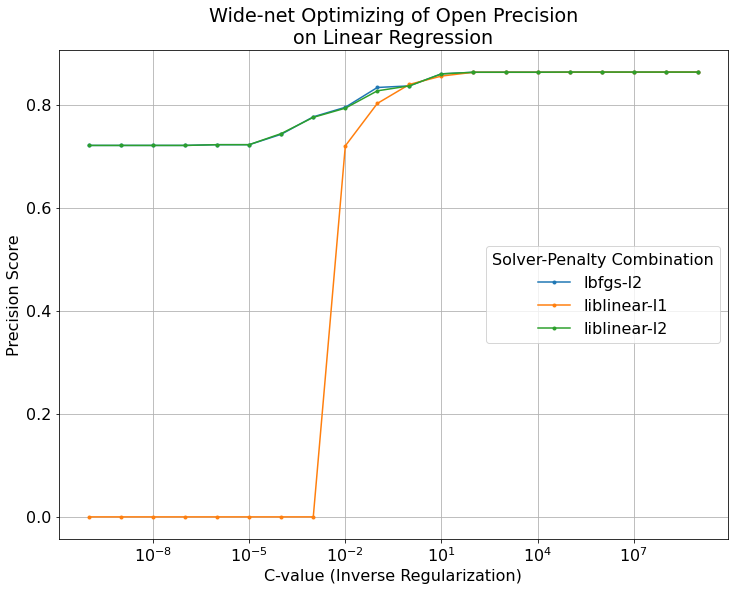

In [71]:
# plot all of our cross val scores
plt.figure(figsize = (12,9))

# plot each solver-penalty combo as its own line
for solver, penalty in params:
    plt.plot(C_values,
             cross_val_scores[f"{solver}-{penalty}"],
             label = f"{solver}-{penalty}",
             marker = '.')

# add legend and grid
plt.legend(title = 'Solver-Penalty Combination',
           loc = 'center right')
plt.grid()

# set x-scale to logarithmic
plt.xscale("log")

# add title and axis legends
plt.title('Wide-net Optimizing of Open Precision\non Linear Regression')
plt.xlabel('C-value (Inverse Regularization)')
plt.ylabel('Precision Score')

plt.show()

The plot above shows us reaching our peak scores somewhere between 1 and 100.  Let's tighten up our c-values and get a closer look.

In [72]:
# dictionary of solver/regularization penalty combinations
params = [['lbfgs', 'l2'],
          ['liblinear', 'l1'],
          ['liblinear', 'l2']]

# generate wide range of C values
C_values = 10.0**np.arange(0, 2, 0.1)

# store the results in dictionary where each value is an array of cross val scores for each
# param set
cross_val_scores = {}

# define our callable scorer object using sklearn make scorer
open_precision_scorer = make_scorer(precision_score, pos_label = 1)


# loop through all of all parameter combinations
for solver, penalty in params:
    
    # array to store cross val scores for each c-value
    cross_val_c_scores = []
    
    # loop through each c value
    for c in C_values:
        
        # instantiate model
        logmod = LogisticRegression(penalty = penalty, C = c, solver = solver, max_iter = 10000)
        
        # score the model on 5 fold cross validation
        cv_score = np.mean(cross_val_score(logmod,
                                           X_train_scaled,
                                           y_train,
                                           cv = 5,
                                           n_jobs = 8,
                                           scoring = open_precision_scorer))
        
        # add this runs scores to our scores array
        cross_val_c_scores.append(cv_score)
    
    # add this solver-penalty combos scores to our dictionary
    cross_val_scores[f"{solver}-{penalty}"] = cross_val_c_scores

In [73]:
# store solver-penalty best score and c value , initialized to zeros
best_result = {'solver-penalty': 0,
               'c-val': 0,
               'score': 0}

# loop through param combinatinos
for solver, penalty in params:
    
    # get the best score/c-value combo
    best_score_c = max(zip(cross_val_scores[f"{solver}-{penalty}"], C_values))
    
    # store the new result if it is the best
    if best_result['score'] < best_score_c[0]:
        best_result['solver-penalty'] = f"{solver}-{penalty}"
        best_result['c-val'] = best_score_c[1]
        best_result['score'] = best_score_c[0]

In [74]:
# dictionary to store the metric/model name/data frame/hyperparameters
metric_info_for_optimizing['open_precision'] = {'model': 'Logistic Regression',
                                                'hyperparameters': best_result}

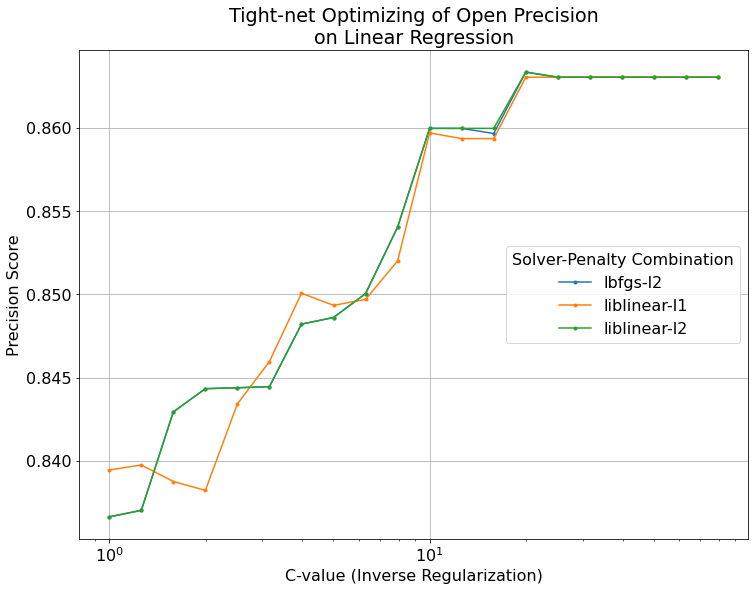

In [75]:
# plot all of our cross val scores
plt.figure(figsize = (12,9))

# plot each solver-penalty combo as its own line
for solver, penalty in params:
    plt.plot(C_values,
             cross_val_scores[f"{solver}-{penalty}"],
             label = f"{solver}-{penalty}",
             marker = '.')

# add legend and grid
plt.legend(title = 'Solver-Penalty Combination',
           loc = 'center right')
plt.grid()

# set x-scale to logarithmic
plt.xscale("log")

# add title and axis legends
plt.title('Tight-net Optimizing of Open Precision\non Linear Regression')
plt.xlabel('C-value (Inverse Regularization)')
plt.ylabel('Precision Score')

plt.show()

In [76]:
# print out our best c-val and score
print(best_result)

{'solver-penalty': 'lbfgs-l2', 'c-val': 19.952623149688797, 'score': 0.8633511681826288}


The above plot and output show us that our best solver is the lbfgs with a regularization function l2 (ridge regression) and a c-value of 19.9526.

We have now optimized parameters for 5 models, one for each of the metrics we are tracking.  The next steps are going to be training 4 models, one for each areas of expertise.  Becuase closed precision and open recall ended up using KNN with the same number of neighbours on the same data, we only need one model to cover each of those two metrics.  We will score each of these four optimized models to see if they are producing better results.  If they are, we will proceed to stack them and attempt to use a meta model to increase our over all accuracy even further.

#### Model Iteration VII - Scoring Optimized Models on Test Data

With our hyperparameters tuned, let's move ahead and fit our models on our entire training set and see what improvements we have made.  We know that we are training on two different data sets (one upsampled, one not), so let's build those out first.  We will then:
- fit each model
- score each model on the test set
- plot our models to see if we have made an improvement in any of our categories

In [208]:
# split data in to dependent and independent variables using data from model IV
X_IV = peak_df3.drop(columns = ['day_status_L0h'])
y_IV = peak_df3['day_status_L0h']

# split data into train and test
X_train_IV, X_test_IV, y_train_IV, y_test_IV = train_test_split(X_IV, y_IV, stratify = y_IV, test_size=0.3, random_state=42)

# fit scaler on train data and transform
scaler = StandardScaler()
X_train_IV_scaled = scaler.fit_transform(X_train_IV)

# scale test data
X_test_IV_scaled = scaler.transform(X_test_IV)

In [78]:
# split data in to dependent and independent variables using data from model VI
X_VI = peak_df4.drop(columns = ['day_status_L0h'])
y_VI = peak_df4['day_status_L0h']

# split data into train and test
X_train_VI, X_test_VI, y_train_VI, y_test_VI = train_test_split(X_VI, y_VI, stratify = y_IV, test_size=0.3, random_state=42)

# calculate number of samples to generate for balanced classes
# number of open days minus number of current closed days
n_samples = X_train_VI[y_train_VI == 1].shape[0] - X_train_VI[y_train_VI == 0].shape[0]

# generate additional samples by making perfectly balanced classes
X_upsampled, y_upsampled = resample(X_train_VI[y_train_VI == 0],
                                    y_train_VI[y_train_VI == 0],
                                    replace = True,
                                    n_samples = n_samples,
                                    random_state = 42)

# combine upsamples with original data so classes are balanced
# ensure upsamples are tagged on the end only so we can remove them later ...
X_train_VI = np.vstack((X_train_VI, X_upsampled))
y_train_VI = np.hstack((y_train_VI, y_upsampled))

# fit scaler on train data and transform
scaler = StandardScaler()
X_train_VI_scaled = scaler.fit_transform(X_train_VI)

# scale test data
X_test_VI_scaled = scaler.transform(X_test_VI)

Now that we have the two test sets we are going to work with, let's fit each of the models with their respective hyper parameters.

##### Accuracy

In [79]:
# get the parameters for accuracy
hyperparams = metric_info_for_optimizing['accuracy']['hyperparameters']
hyperparams

{'solver-penalty': 'liblinear-l1',
 'c-val': 0.15848931924611173,
 'score': 0.8755964280954285}

In [80]:
# get params out
solver_penalty = hyperparams['solver-penalty'].split('-')
solver = solver_penalty[0]
penalty = solver_penalty[1]
c_val = hyperparams['c-val']

# instantiate accuracy model
logmod_accuracy = LogisticRegression(solver = solver,
                                     penalty = penalty,
                                     C = c_val)

# fit model
logmod_accuracy.fit(X_train_IV_scaled, y_train_IV)

LogisticRegression(C=0.15848931924611173, penalty='l1', solver='liblinear')

In [81]:
# score logistic accuracy
y_pred = logmod_accuracy.predict(X_test_IV_scaled)
print(classification_report(y_test_IV, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.67      0.75        60
         1.0       0.91      0.97      0.94       202

    accuracy                           0.90       262
   macro avg       0.89      0.82      0.85       262
weighted avg       0.90      0.90      0.90       262



With an accuracy score of 90% on our optimized model, we have not seen any improvement over the un-optimized model.

##### Closed Precision/Open Recall

In [82]:
# get the params for closed precision/open recall
hyperparams = metric_info_for_optimizing['closed_precision']['hyperparameters']
hyperparams

{'n_neighbours': 17}

In [83]:
# get params out
n = hyperparams['n_neighbours']

# instantiate closed precision model
knn_closed_precision_open_recall = KNeighborsClassifier(n_neighbors = n)

# fit model
knn_closed_precision_open_recall.fit(X_train_IV_scaled, y_train_IV)

KNeighborsClassifier(n_neighbors=17)

In [84]:
# score knn closed percision/open recall
y_pred = knn_closed_precision_open_recall.predict(X_test_IV_scaled)
print(classification_report(y_test_IV, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.30      0.46        60
         1.0       0.83      1.00      0.90       202

    accuracy                           0.84       262
   macro avg       0.89      0.65      0.68       262
weighted avg       0.85      0.84      0.80       262



Our KNN model optimized for both closed precision and open recall has actually lost one point of closed precision, but it has increased its overall accuracy score.  We are fine with this.

##### Closed Recall

In [85]:
# get the params for open precision
hyperparams = metric_info_for_optimizing['closed_recall']['hyperparameters']
hyperparams

{'solver-penalty': 'lbfgs-l2',
 'c-val': 79.43282347242817,
 'score': 0.8723404255319149}

In [86]:
# get params out
solver_penalty = hyperparams['solver-penalty'].split('-')
solver = solver_penalty[0]
penalty = solver_penalty[1]
c_val = hyperparams['c-val']

# instantiate accuracy model
logmod_closed_recall = LogisticRegression(solver = solver,
                                           penalty = penalty,
                                           C = c_val,
                                           max_iter = 10000)

# fit model
logmod_closed_recall.fit(X_train_VI_scaled, y_train_VI)

LogisticRegression(C=79.43282347242817, max_iter=10000)

In [87]:
# score logistic closed recall
y_pred = logmod_closed_recall.predict(X_test_VI_scaled)
print(classification_report(y_test_VI, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.83      0.74        60
         1.0       0.95      0.88      0.91       202

    accuracy                           0.87       262
   macro avg       0.81      0.85      0.83       262
weighted avg       0.88      0.87      0.87       262



Optimizing for closed recall with a logistic model has not increased out closed recall score.  This model does have a higher overall accuracy than the un-optimized version, so hopefully this well help once it comes to stacking.

##### Open Precision

In [88]:
# get the params for open precision
hyperparams = metric_info_for_optimizing['open_precision']['hyperparameters']
hyperparams

{'solver-penalty': 'lbfgs-l2',
 'c-val': 19.952623149688797,
 'score': 0.8633511681826288}

In [89]:
# get params out
solver_penalty = hyperparams['solver-penalty'].split('-')
solver = solver_penalty[0]
penalty = solver_penalty[1]
c_val = hyperparams['c-val']

# instantiate accuracy model
logmod_open_precision = LogisticRegression(solver = solver,
                                           penalty = penalty,
                                           C = c_val,
                                           max_iter = 10000)

# fit model
logmod_open_precision.fit(X_train_VI_scaled, y_train_VI)

LogisticRegression(C=19.952623149688797, max_iter=10000)

In [90]:
# score logistic open precision
y_pred = logmod_open_precision.predict(X_test_VI_scaled)
print(classification_report(y_test_VI, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.83      0.74        60
         1.0       0.95      0.87      0.91       202

    accuracy                           0.86       262
   macro avg       0.80      0.85      0.82       262
weighted avg       0.88      0.86      0.87       262



Optimizing for open precision with a logistic model has lost us one point on that metric.  But again, the model has a higher over all accuracy score, and we are hoping that bodes well for stacking.

### Model Iteration VIII - Stacking

Our initial hope here was to use sklearn's ensemble stacking functionallity to stack our models.  But because we have taken the approach of training different models on different data sets with various hyperparameters, this is not going to be possible.  There is a [current open pull request](https://github.com/scikit-learn/scikit-learn/pull/16748) on gitHub asking for the possability of this functionallity, so this makes us a little more comfortable with this approach.

We are now going to have to essentially build our own version of a stacking model.  The steps are roughly going to be:
- get the predicted probabilities out of each model for the training data
- wrangle them into a data frame of features
    - keep probability of open only to avoid co-linearity
    - we will end up with rows with missing values.  Two or our models were trained on upsampled data, which was all tacked on at the end of the matricies.  There will be `NaN` values in our other two model columns, so we can simply drop all rows with missing values.
- use this new feature set to train a logistic regression with cross validation
- train a final logistic regression model on our new feature set with hyper parameters
- get predicted probabilites our of each model for our test data
- wrangle these into a data frame of features
- pass this into our final optimized logistic regression model for a final evaluation
- drink heavily to either celebrate success or drown our sorrows after spending too many hours optimizing for nothing (just kidding - but figured if anyone has read the entire project/report and is still paying attention we should inject something off-beat) 

In [91]:
# build list of models
model_probas = []

# get probabilities for each test set - keep the scores for open only
model_probas.append(logmod_accuracy.predict_proba(X_train_IV_scaled)[:, 1].tolist())
model_probas.append(knn_closed_precision_open_recall.predict_proba(X_train_IV_scaled)[:, 1].tolist())
model_probas.append(logmod_closed_recall.predict_proba(X_train_VI_scaled)[:, 1].tolist())
model_probas.append(logmod_open_precision.predict_proba(X_train_VI_scaled)[:, 1].tolist())

In [92]:
# build a data frame from our proba scores
stacked_df = pd.DataFrame(model_probas).T

# remove the last rows, which we know are all dupicates because of how we built the
# upsampling matricies - they will be the only ones with NaN in them.  Our upsampled
stacked_df = stacked_df.dropna()

# confirm this gives us the same number of rows as logmod_accuracy and knn_closed_precision_open_recall
stacked_df.shape[0] == len(model_probas[0])


True

In [93]:
# turn df back into a numpy array
X_train_stacked = stacked_df.to_numpy()

# get nicely labelled y_train data
y_train_stacked = y_train_IV

Now that we have our data, let's optimize a linear regression on it.

In [94]:
# dictionary of solver/regularization penalty combinations
params = [['lbfgs', 'l2'],
          ['liblinear', 'l1'],
          ['liblinear', 'l2']]

# generate wide range of C values
C_values = 10.0**np.arange(-10, 10, 1)

# store the results in dictionary where each value is an array of cross val scores for each
# param set
cross_val_scores = {}

# loop through all of all parameter combinations
for solver, penalty in params:
    
    # array to store cross val scores for each c-value
    cross_val_c_scores = []
    
    # loop through each c value
    for c in C_values:
        
        # instantiate model
        logmod_stacked = LogisticRegression(penalty = penalty, C = c, solver = solver, max_iter = 10000)
        
        # score the model on 5 fold cross validation
        cv_score = np.mean(cross_val_score(logmod_stacked,
                                           X_train_stacked,
                                           y_train_stacked,
                                           cv = 5,
                                           n_jobs = 8))
        
        # add this runs scores to our scores array
        cross_val_c_scores.append(cv_score)
    
    # add this solver-penalty combos scores to our dictionary
    cross_val_scores[f"{solver}-{penalty}"] = cross_val_c_scores

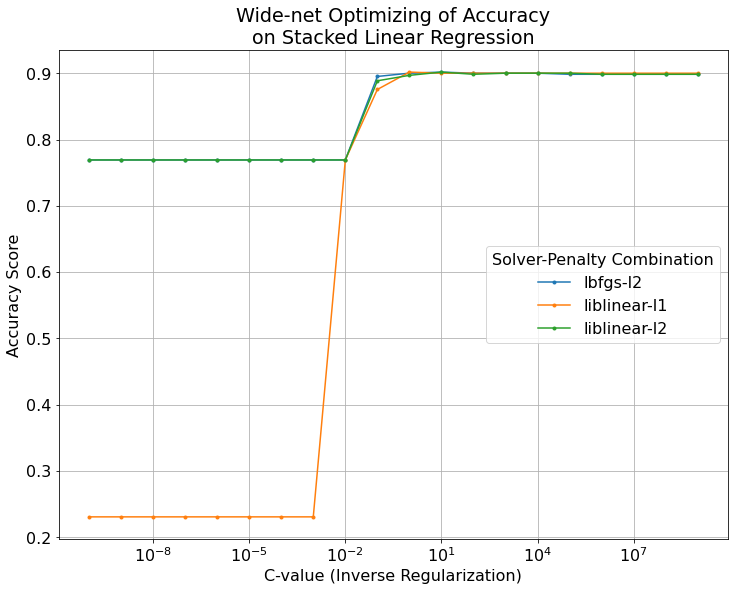

In [95]:
# plot all of our cross val scores
plt.figure(figsize = (12,9))

# plot each solver-penalty combo as its own line
for solver, penalty in params:
    plt.plot(C_values,
             cross_val_scores[f"{solver}-{penalty}"],
             label = f"{solver}-{penalty}",
             marker = '.')

# add legend and grid
plt.legend(title = 'Solver-Penalty Combination',
           loc = 'center right')
plt.grid()

# set x-scale to logarithmic
plt.xscale("log")

# add title and axis legends
plt.title('Wide-net Optimizing of Accuracy\non Stacked Linear Regression')
plt.xlabel('C-value (Inverse Regularization)')
plt.ylabel('Accuracy Score')

plt.show()

So it looks like our stacking has probably had little effect.  Let's keep moving forward though.  From the above it looks like we should zoom in on c-values from 0.1 to 10.

In [96]:
# dictionary of solver/regularization penalty combinations
params = [['lbfgs', 'l2'],
          ['liblinear', 'l1'],
          ['liblinear', 'l2']]

# generate wide range of C values
C_values = 10.0**np.arange(-1, 1, 0.1)

# store the results in dictionary where each value is an array of cross val scores for each
# param set
cross_val_scores = {}

# loop through all of all parameter combinations
for solver, penalty in params:
    
    # array to store cross val scores for each c-value
    cross_val_c_scores = []
    
    # loop through each c value
    for c in C_values:
        
        # instantiate model
        logmod_stacked = LogisticRegression(penalty = penalty, C = c, solver = solver, max_iter = 10000)
        
        # score the model on 5 fold cross validation
        cv_score = np.mean(cross_val_score(logmod_stacked,
                                           X_train_stacked,
                                           y_train_stacked,
                                           cv = 5,
                                           n_jobs = 8))
        
        # add this runs scores to our scores array
        cross_val_c_scores.append(cv_score)
    
    # add this solver-penalty combos scores to our dictionary
    cross_val_scores[f"{solver}-{penalty}"] = cross_val_c_scores

In [97]:
# store solver-penalty best score and c value , initialized to zeros
best_result = {'solver-penalty': 0,
               'c-val': 0,
               'score': 0}

# loop through param combinatinos
for solver, penalty in params:
    
    # get the best score/c-value combo
    best_score_c = max(zip(cross_val_scores[f"{solver}-{penalty}"], C_values))
    
    # store the new result if it is the best
    if best_result['score'] < best_score_c[0]:
        best_result['solver-penalty'] = f"{solver}-{penalty}"
        best_result['c-val'] = best_score_c[1]
        best_result['score'] = best_score_c[0]

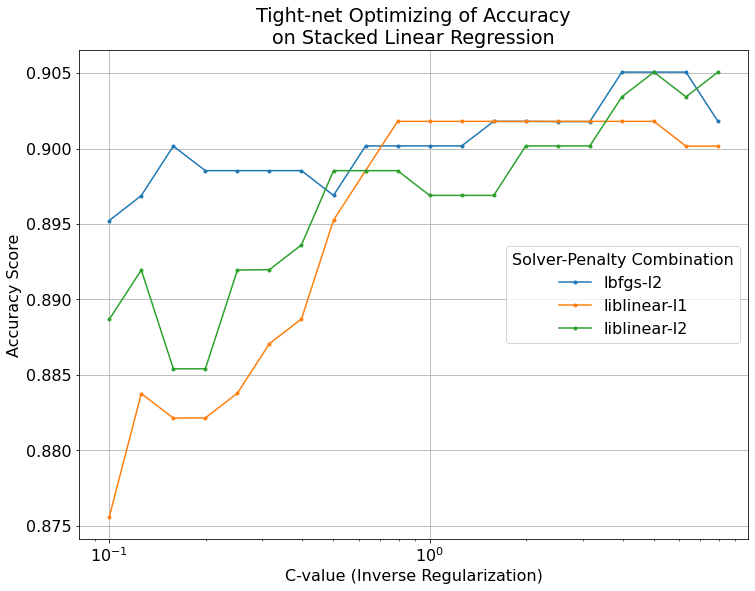

In [98]:
# plot all of our cross val scores
plt.figure(figsize = (12,9))

# plot each solver-penalty combo as its own line
for solver, penalty in params:
    plt.plot(C_values,
             cross_val_scores[f"{solver}-{penalty}"],
             label = f"{solver}-{penalty}",
             marker = '.')

# add legend and grid
plt.legend(title = 'Solver-Penalty Combination',
           loc = 'center right')
plt.grid()

# set x-scale to logarithmic
plt.xscale("log")

# add title and axis legends
plt.title('Tight-net Optimizing of Accuracy\non Stacked Linear Regression')
plt.xlabel('C-value (Inverse Regularization)')
plt.ylabel('Accuracy Score')

plt.show()

In [99]:
print(best_result)

{'solver-penalty': 'lbfgs-l2', 'c-val': 6.309573444801926, 'score': 0.9050646408103425}


So our next step is to train our final stacked logistic model with the hyperparameters determined above.

In [100]:
# instantiate model
logmod_stacked = LogisticRegression(solver = 'lbfgs',
                                    penalty = 'l2',
                                    C = 6.30957,
                                    max_iter = 10000)

# train it on the training data
logmod_stacked.fit(X_train_stacked, y_train_stacked)

LogisticRegression(C=6.30957, max_iter=10000)

With our model trained, we now need to get the predicted probabilites of the test set out of the prior models and wrangle them into a the format our stacked model is expecting.

In [101]:
# build list of models
model_probas = []

# get probabilities for each test set - keep the scores for open only
model_probas.append(logmod_accuracy.predict_proba(X_test_IV_scaled)[:, 1].tolist())
model_probas.append(knn_closed_precision_open_recall.predict_proba(X_test_IV_scaled)[:, 1].tolist())
model_probas.append(logmod_closed_recall.predict_proba(X_test_VI_scaled)[:, 1].tolist())
model_probas.append(logmod_open_precision.predict_proba(X_test_VI_scaled)[:, 1].tolist())

In [102]:
# build a data frame from our proba scores
stacked_df = pd.DataFrame(model_probas).T

# turn df back into a numpy array
X_test_stacked = stacked_df.to_numpy()

# get nicely labelled y_test data
y_test_stacked = y_test_IV

And the final moment of truth.  Time to generate preditions with our stacked logistic regression model on the matrix of predictions from the models at the 'base' of the stack.

In [103]:
# score final stacked model
y_pred = logmod_stacked.predict(X_test_stacked)
print("Results of Stacked Logistic")
print(confusion_matrix(y_test_stacked, y_pred))
print(classification_report(y_test_stacked, y_pred))

Results of Stacked Logistic
[[ 41  19]
 [  9 193]]
              precision    recall  f1-score   support

         0.0       0.82      0.68      0.75        60
         1.0       0.91      0.96      0.93       202

    accuracy                           0.89       262
   macro avg       0.87      0.82      0.84       262
weighted avg       0.89      0.89      0.89       262



In [104]:
y_pred = logmod_accuracy.predict(X_test_IV_scaled)
print("Results of Previously Best Logistic Model")
print(confusion_matrix(y_test_IV, y_pred))
print(classification_report(y_test_IV, y_pred))

Results of Previously Best Logistic Model
[[ 40  20]
 [  6 196]]
              precision    recall  f1-score   support

         0.0       0.87      0.67      0.75        60
         1.0       0.91      0.97      0.94       202

    accuracy                           0.90       262
   macro avg       0.89      0.82      0.85       262
weighted avg       0.90      0.90      0.90       262



From the above two tables we can see that our stacked model has actually reduced our accuracy by one percentage point.  This leaves us with a best model of Logisitic Regression.  The nice thing about this is it will mean we are able to do some interpretation of the coefficients.

### Evalaution - Checking Decision Boundry

Our model by default sets a decision boundry of 50% on the output probability.  Let's get the probability scores for the Peak chair being open from our best model and see if adjusting the threashold would have any effect on our overall accuracy.  We will assess this via a plot.

In [105]:
# get the probability of open only
model_predictions = logmod_accuracy.predict_proba(X_test_IV_scaled)[:, 1].tolist()

# list to store accuracy at each threashold
accuracies = []

# threasholds to check
threasholds = np.arange(0, 1, 0.01)

# loop over threashold values
for threashold in threasholds:
    
    # binarize the prediction
    model_predictions_binarized = np.where(model_predictions > threashold, 1, 0)
    accuracies.append((model_predictions_binarized == y_test_IV).sum()/len(y_test_IV))

In [106]:
# build dictionary of threashold:accuracy pairs
accuracies_dict = dict(zip(threasholds, accuracies))

# get max value from dictionary
max_value = max(accuracies_dict.values())

# get threashold value of max accuracy
best_threashold = [k for k, v in accuracies_dict.items() if v == max_value]

print(f"At the default threashold of 0.5, accuracy is {100*accuracies_dict[0.5]:.1f}%")
print(f"At a threashold of {best_threashold[0]} our accuracy improves to {100*max_value: .1f}%")

At the default threashold of 0.5, accuracy is 90.1%
At a threashold of 0.62 our accuracy improves to  90.8%


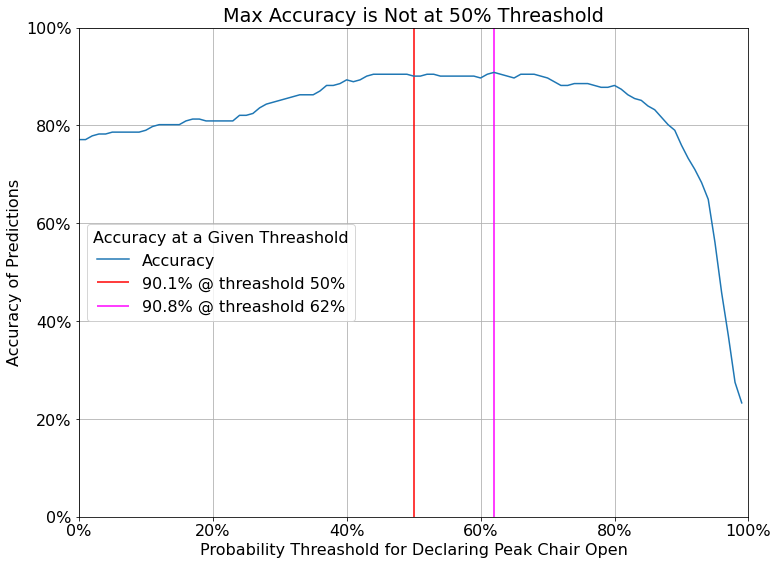

In [107]:
# plot accuracies vs threasholds

# build figure
fig, ax = plt.subplots(figsize = (12,9))

# plot data
ax.plot(threasholds, accuracies, label = 'Accuracy')
ax.vlines(0.5, 0, 1, color = 'red', label = '90.1% @ threashold 50%')
ax.vlines(best_threashold[0], 0, 1, color = 'magenta', label = "90.8% @ threashold 62%")

# title, labels, grid
plt.title('Max Accuracy is Not at 50% Threashold')
plt.xlabel('Probability Threashold for Declaring Peak Chair Open')
plt.ylabel('Accuracy of Predictions')
plt.grid()

# modify axis ticks
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# modify axix limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# turn on legend and move on chart
plt.legend(title = 'Accuracy at a Given Threashold', loc = 'center left')

plt.show()


From the plot above, we can see that it is possible to achieve an increase of almost one percentage point by modifying the threashold for declaring the Peak chair open from a probability of 50% to a probability of 62%.  The improvement might seem small, but in relative terms, we have just covered almost 10% of our remaining error with very little effort.

### Evaluation - Looking for Patterns in Misclassification

Without a deep dive into what the misclassified points may have in common, our fist intuition is that many of the mis-classified days happen early in the season.  Let's plot a heatmap to see if the days earlier in the season have more errors.  We are going to do this using the entire data set.  The reason for this is that if we look at either the test set or the training set independently, we will be missing random values from throughout the seasons based on how the train-test-split method seperated the data.  This might give us misconceptions about patterns in the data.  We acknowledge that this might not be best practice, but since we will do no more modelling on this data set (for this report) we feel it will be an interesting insight.

In [209]:
# scale all of our data with the latest trained scaler
X_IV_scaled = scaler.transform(X_IV)

In [210]:
# get the probability of open only
model_predictions = logmod_accuracy.predict_proba(X_IV_scaled)[:, 1].tolist()

# set threashold - no idea why we had to do it this way, but it worked.
threashold = np.arange(0.62, 0.621, 0.01)

# get predictions at threashold
model_predictions_binarized = np.where(model_predictions > threashold[0], 1, 0)

In [211]:
# get single array where 1 is false positive, 0 is accurate, and -1 is false negative
predictions_vs_actual = model_predictions_binarized - y_IV

# sort in date order
predictions_vs_actual.sort_index(inplace = True)

# put into dataframe so we can plot (heatmap doesn't do 1D arrays)
pred_vs_act_df = pd.DataFrame(predictions_vs_actual)

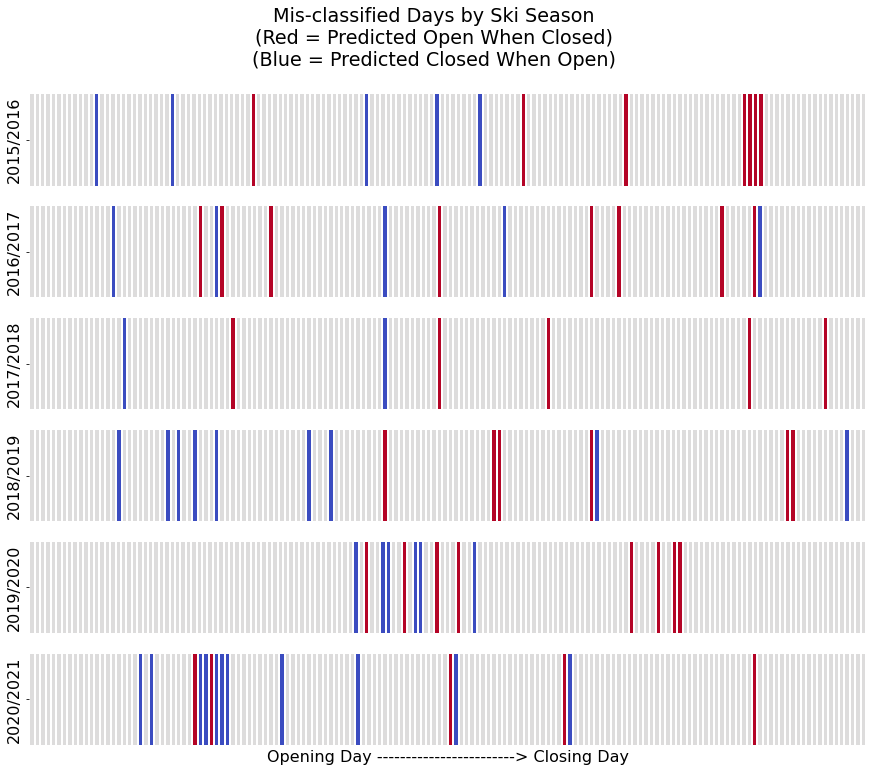

In [213]:
# plot a heatmap
fig, axes = plt.subplots(6, figsize = (15,12))

# list of years to loop through - skip first season as it is only started at January
years = np.arange(2015, 2021, 1)

# loop through seasons except the first and store them
for ax, yr in zip(axes, years):
    
    # get this seasons values
    yr_df = pred_vs_act_df[(pred_vs_act_df.index > datetime(yr, 5, 1).date()) &
                           (pred_vs_act_df.index < datetime(yr + 1, 5, 1).date())]
    
    # fixed start and end dates for all seasons so the plots line up
    idx = pd.date_range(f'{yr}-11-15', f'{yr + 1}-4-17')
    
    # re index to include uniform date range, fill blanks with zeros so they show up as neutral on the plot.
    yr_df = yr_df.reindex(idx, fill_value = 0)
    
    # set the column name
    yr_df.rename(columns = {'day_status_L0h': f"{yr}/{yr + 1}"}, inplace = True )
    
    # transpose to plot horizontally
    yr_df = yr_df.T
    
    sns.heatmap(yr_df,
                cmap = 'coolwarm',
                linewidths = 0.01,
                xticklabels = False,
                vmin = -1,
                vmax = 1,
                ax = ax,
                cbar = False)

# add x-label to last axis
ax.set_xlabel("Opening Day ------------------------> Closing Day")

# set title
fig.suptitle('Mis-classified Days by Ski Season\n(Red = Predicted Open When Closed)\n(Blue = Predicted Closed When Open)')

plt.show()

The above plot illuminates a number of interesting facts:
- **Early Season**
    - Over all, we can state that during the early season, our model error tends to be predicting the Peak chair is closed when it is open.  This supports our theory and approach that calculating a snow pack depth at 2,000m to establish a more uniform snow pack depth on opening day would help in reducing some of our error.
- **Late Season**
    - On balance, we can state that during the later season our model error tends to be predicting the Peak chair is open when it is in fact closed.  We know that heaviest precipitation months are [March and April](https://www.snow-forecast.com/resorts/Whistler-Blackcomb/history), but whether that falls as rain or snow is always up to chance.  It is very possible many of those days mis-classified in later season were because the freezing level was somewhere between the Pig Alley weather station and the Peak chair.  This would cause snow at the Peak chair and that would require additional avalanche control, which would lead to a higher probability of the lift being closed on any given day.
- **Odd Man Out**
    - The 2019/2020 season looks very different from all the others.  We happened to have picked out during our 5th model iteration that 2019/2020 was an unusually cold season throughout.  This would have meant less variation in snow pack and snow fall across the mountain, especially in the early season.  We can see from the above there were zero errors early 2019/2020 season.  This further supports our idea that snowpack at 2,000m would be a useful feature to have.
    - It is also worth noting the lack of errors in late season for 2019/2020 and 2020/2021.  Both of these seasons were truncated early due to COVID-19.  The lack of errors is an artifact of the graph construction.

### Evaluation - Exploring Model Coefficients

We have had the fortune of our best model being a logistic regression.  We would be remiss if we did not explore the coefficients of the model to get a better sense of which of our features were truely important.  We will pull the features out of the model and plot them with their log-odds.

In [220]:
# get coefficients from the model
coefs = logmod_accuracy.coef_[0]

# get the column names from our training data frame
col_names = X_IV.columns

# put into dataFrame
coefs_df = pd.DataFrame(coefs, index = col_names, columns = ['logmod_coefs'])

# sort to put largest value first
coefs_df.sort_values('logmod_coefs', ascending = True, inplace = True)

# calculate odds ratio
coefs_df['odds_ratio'] = coefs_df['logmod_coefs'].apply(lambda x: np.exp(x))

# get some stats on the odss_ratio column
coefs_df['odds_ratio'].describe()

count    80.000000
mean      1.025187
std       0.179301
min       0.568578
25%       1.000000
50%       1.000000
75%       1.000000
max       2.214996
Name: odds_ratio, dtype: float64

From a quick look at the distribution of odds ratios, we can see that at least half of our features had an odds ratio of precisely one.  This means that all of these features had no effect on the outcome of the model at all.  It looks like we should have done a better job of identifying this ahead of time and removing these features as they were just noise.

For now, let's filter out all the features with a ratio equal to one (as they are of no interest) and then plot the remaining features.

Total number of features in model: 24
Number of features in model that do not have an odds ratio of one: 24


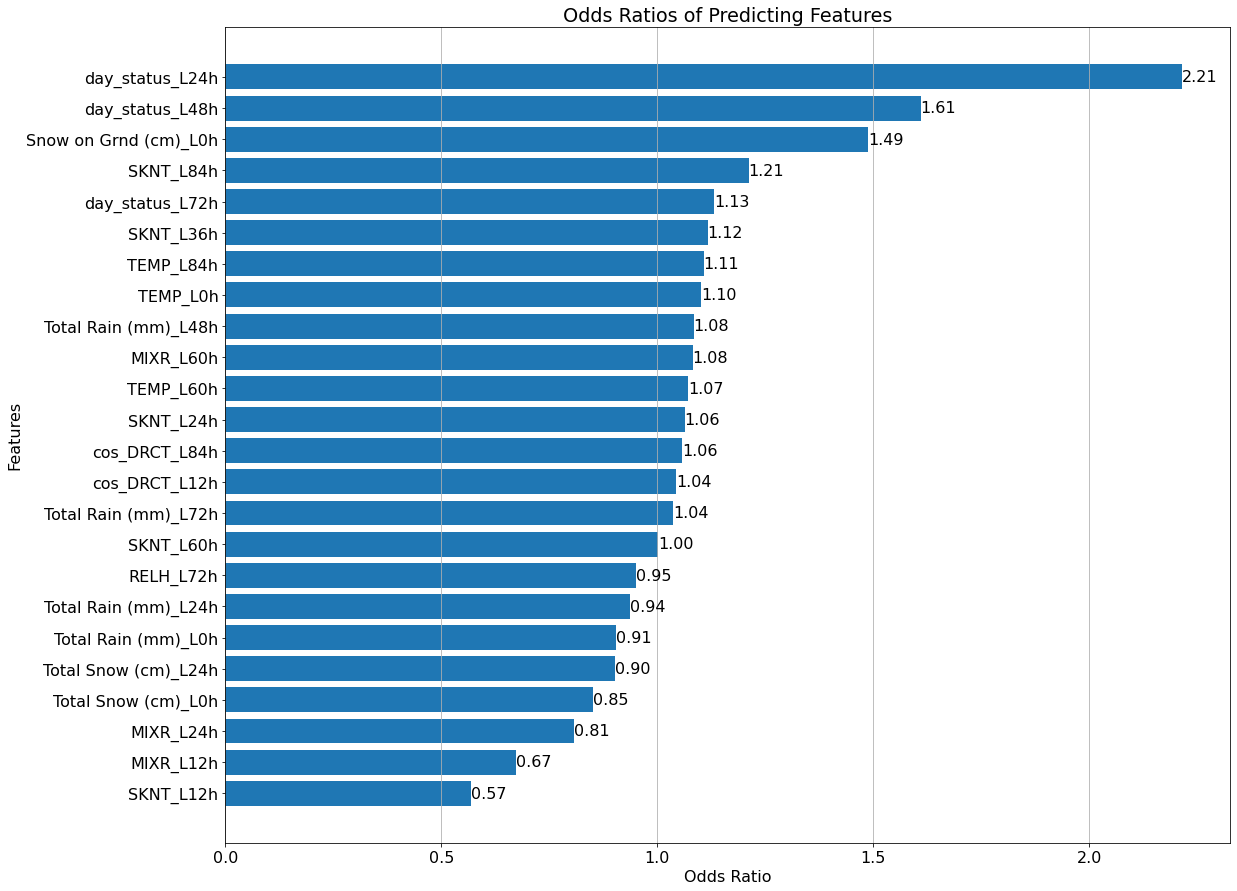

In [226]:
# print out number of features total
print(f"Total number of features in model: {coefs_df.shape[0]}")

# filter out all features with a ratio of 1
coefs_df = coefs_df[coefs_df['odds_ratio'] != 1.0]

# print out number of features that were not one
print(f"Number of features in model that do not have an odds ratio of one: {coefs_df.shape[0]}")

# setup plot
fig, ax = plt.subplots(figsize=(18,15))

# plot data
hbars = ax.barh(coefs_df.index, coefs_df['odds_ratio'])

# turn the grid on x axis only
ax.grid(axis = 'x')

# label axis
ax.set_xlabel('Odds Ratio')
ax.set_ylabel('Features')

# add labels to bars
ax.bar_label(hbars, fmt='%.2f')

# set plot title
ax.title.set_text('Odds Ratios of Predicting Features')

The above plot gives us some great insights into what is driving our models predictions.  Let's take a moment to chat about several of these:
- **day_status**:
    - This is the open/closed status of the lift on any given day.  Here we can see that three of our top 5 predictors are the status of the Peak chair one, two, and three days ahead of the day we are trying to predict.  A lift status the previous day of open was our strongest predictor of the Peak chair being open on our target day by far, increasing the odds by a factor of 2.21.
- **Snow on Grnd (cm)**:
    - This is the snowpack base depth.  We have explored and discussed this extensively and so we are happy to see it with such a strong odds ratio.  For every 1cm increase in the snow pack, the odds of the lift opening increase by a factor of 1.49.  We feel this further supports the idea that having snowpack depth at 2,000m would increase our model accuracy
- **SKNT**:
    - This is the wind speed at 3,000m evelvation in km/hr.  As expected, wind speed at 4AM the day of our predictions is the biggest factor reducing the odds of the Peak chair opening that day.  For every 1 km/hr increase in wind speed, the odss of the lift opening decrease by almost half.
    - Interestingly, the wind speed at 4AM the day prior to our prediction day increases the odds of the Peak chair opening by a factor of 1.12.  We cannot think of a mechanism for why this might be.
- **MIXR**:
    - This is the ratio of mass of water vapour in the air to the mass of dry air.  Stated simply, this is a good proxy for snow at 3,000m.  So a one unit increase in the mix ratio at 4AM the day the lift is opening reduces the odds of the lift opening by 0.67.  A one unit increase in the mixratio at 4PM the day before we want to predict if the lift will open reduces the odds of the lift opening by a factor of 0.81.
- **Total Snow (cm)**:
    - This is the amount of snow that has fallen at the Pig Alley weather station in the last 24 hours, measured at 6AM each day.  As expeted, snow the day of and snow the previous day both reduce the odds of the Peak chair opening by factors of 0.85 and 0.90 respectively.
- **Total Rain (mm)**:
    - This is the amount of rain that has fallen at the Pig Alley weather station in the last 24 hours, measred at 6AM each day.  Rain in the last two days has a small effect in reducing the the odds of the Peak chair opening by factors of 0.91 and 0.90.
    - The reason we feel that rain at the Pig Alley weather station in the days leading up to our target day would reduce the odds of the Peak chair opening is that the temperature difference was such that the precipitation fell as snow at the Peak chair elevation.  We feel this again lends credence to our theory that calculating snow fall at 2,000m would provide us with a better model result.
    
The last item that is worth noting is the lack of wind direction as a significant factor.  Our EDA indicated there was some correlation with wind direction, but apparenlty not enough to factor into our final model.

### Conclusion

We have shown that with a Logistic Regression model we can achieve an accuracy of 90.8% when predicting if the Peak chair on Whistler mountain will open on any given day during the ski season.  The three strongest factors increasing the odds of the Peak chair opening were the chair being open yesterday, the chair being open the day before that, and a larger snow pack depth.  The three strongest factors reducing the odds of the Peak chair opening were the wind speed morning of, snow morning of at 3,000m, and snow the afternoon before at 3,000m.